# A predictive approach to estimate the maximum voluntary activation of the shoulder muscles

Romain Martinez<sup>*a</sup>, Jonathan Tremblay<sup>a</sup>, Mickael Begon<sup>a</sup>, Fabien Dal Maso<sup>a</sup>

<sup>a</sup>School of Kinesiology and Exercise Science, Faculty of Medicine, University of Montreal

[GitHub repo](https://github.com/romainmartinez/mvc)

# Part 1: Getting the data

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import scipy.io as sio

# to make this notebook's output stable across runs
RANDOM_SEED = 7
np.random.seed(RANDOM_SEED)

In [2]:
PROJECT_PATH = Path("./")
DATA_PATH = PROJECT_PATH / "data"
MODEL_PATH = PROJECT_PATH / "model"

## Read the data

We start this notebook with data in matlab format, where each file corresponds to different experiments.

Each file contains a 3-dimensional matrix where the first dimension corresponds to the _participant_, the second to the _tested muscle_ and the third to the _test performed_.

![Maximum voluntary isometric contraction tests performed.](./share/fig/positions.svg)

In [3]:
mat = {}
data = {key: [] for key in ("dataset", "participant", "muscle", "test", "mvc")}
dataset_names = []
count = -1


for ifile in DATA_PATH.glob("*only_max.mat"):
    # dataset name
    dataset = ifile.stem.replace("_only_max", "").replace("MVE_Data_", "")
    dataset_names.append(dataset)

    # data
    mat[dataset] = sio.loadmat(ifile)["MVE"]
    print(f"project {dataset}: {mat[dataset].shape[0]} participants")

    for iparticipant in range(mat[dataset].shape[0]):
        count += 1
        for imuscle in range(mat[dataset].shape[1]):
            for itest in range(mat[dataset].shape[2]):
                data["participant"].append(count)
                data["dataset"].append(dataset)
                data["muscle"].append(imuscle)
                data["test"].append(itest)
                data["mvc"].append(mat[dataset][iparticipant, imuscle, itest])

project Romain2017: 32 participants
project Landry2015_1: 14 participants
project Landry2016: 15 participants
project Violon: 10 participants
project Tennis: 16 participants
project Yoann_2015: 22 participants
project Landry2015_2: 11 participants
project Landry2012: 18 participants
project Patrick_2013: 16 participants
project Sylvain_2015: 10 participants
project Landry2013: 21 participants


## Transform the data

In [4]:
df_tidy = pd.DataFrame(data).dropna()
df_tidy["test"] = df_tidy["test"].apply(lambda x: f"test {str(x + 1).zfill(2)}")

MUSCLES = [
    "upper trapezius",
    "middle trapezius",
    "lower trapezius",
    "anterior deltoid",
    "middle deltoid",
    "posterior deltoid",
    "pectoralis major",
    "serratus anterior",
    "latissimus dorsi",
    "supraspinatus",
    "infraspinatus",
    "subscapularis",
]


df_tidy["muscle"] = np.array(MUSCLES)[df_tidy["muscle"]]

print(f"dataset shape = {df_tidy.shape}")
df_tidy.head()

dataset shape = (18465, 5)


,dataset,participant,muscle,test,mvc
0,Romain2017,0,upper trapezius,test 01,0.000381
3,Romain2017,0,upper trapezius,test 04,0.000300
4,Romain2017,0,upper trapezius,test 05,0.000348
5,Romain2017,0,upper trapezius,test 06,0.000111
8,Romain2017,0,upper trapezius,test 09,0.000249


In [5]:
df_wide = df_tidy.pivot_table(
    index=["dataset", "participant", "muscle"],
    columns="test",
    values="mvc",
    fill_value=np.nan,
).reset_index()
df_wide.head()

test,dataset,participant,muscle,test 01,test 02,test 03,test 04,test 05,test 06,test 07,test 08,test 09,test 10,test 11,test 12,test 13,test 14,test 15,test 16
0,Landry2012,120,anterior deltoid,0.013480,0.060322,0.102243,0.262121,0.216671,0.007603,0.009864,0.030523,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Landry2012,120,latissimus dorsi,0.003968,0.077672,0.019619,0.024144,0.021569,0.151734,0.145337,0.060694,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Landry2012,120,lower trapezius,0.025092,0.205321,0.300761,0.170296,0.191271,0.070199,0.140505,0.017468,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Landry2012,120,middle deltoid,0.028731,0.145174,0.170468,0.085861,0.121181,0.035754,0.009872,0.011396,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Landry2012,120,middle trapezius,0.011083,0.135626,0.130890,0.042650,0.062615,0.046499,0.040964,0.016394,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Part 2: Data exploration

In [6]:
df_wide['participant'].nunique()

185

In [7]:
import altair as alt
from altair import datum
alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

## Muscles and tests count

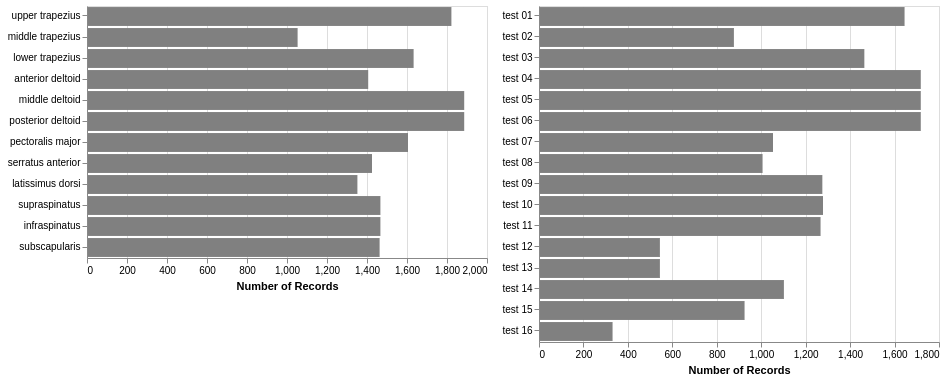

In [8]:
base = alt.Chart(df_tidy).encode(x="count()")
muscle = base.mark_bar(color='grey').encode(alt.Y("muscle", sort=alt.Sort(MUSCLES), title=None))
test = base.mark_bar(color='grey').encode(alt.Y("test", title=None))
(muscle | test)#.properties(title="Number of records by muscle & test")

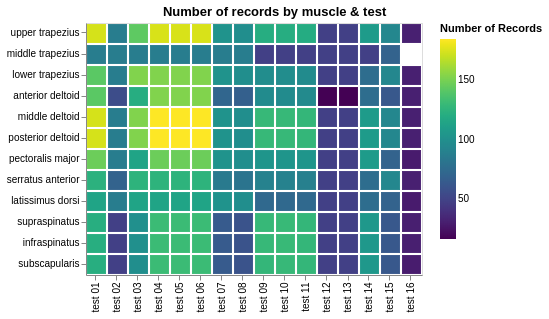

In [9]:
alt.Chart(df_tidy).mark_rect().encode(
    alt.X("test", title=None),
    alt.Y("muscle", sort=alt.Sort(MUSCLES), title=None),
    color="count()",
).properties(title="Number of records by muscle & test")

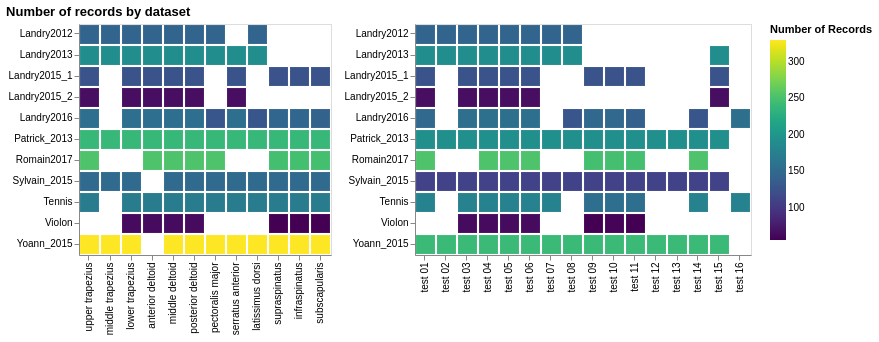

In [10]:
base = alt.Chart(df_tidy).encode(alt.Y("dataset", title=None), color="count()")
test = base.mark_rect().encode(alt.X("test", title=None))
muscle = base.mark_rect().encode(alt.X("muscle", sort=alt.Sort(MUSCLES), title=None))
(muscle | test).properties(title="Number of records by dataset")

## NaNs count

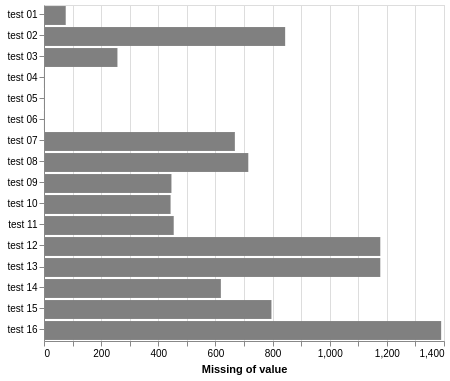

In [11]:
alt.Chart(df_wide.melt(id_vars=["dataset", "participant", "muscle"])).mark_bar(color='grey').encode(
    alt.X("missing(value)"), alt.Y("test", title=None)
)

## Which test normalizes which muscle

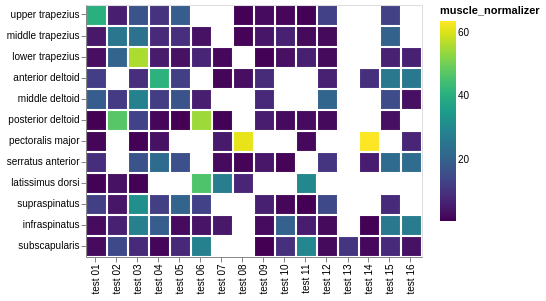

In [12]:
dff = df_tidy.groupby(["test", "muscle"])["mvc"].count().rename("count").to_frame()

max_test = (
    df_tidy.groupby(["participant", "muscle"], as_index=False)
    .apply(lambda x: x["test"][x["mvc"].idxmax()])
    .rename("test")
    .reset_index()
)

dff = dff.merge(
    max_test.groupby(["muscle", "test"]).count().reset_index(), on=["muscle", "test"]
).rename(columns={"participant": "max_test"})


dff["muscle_normalizer"] = dff["max_test"] / dff["count"] * 100

alt.Chart(dff).mark_rect().encode(
    alt.X("test", title=None),
    alt.Y("muscle", sort=alt.Sort(MUSCLES), title=None),
    alt.Color("muscle_normalizer"),
)

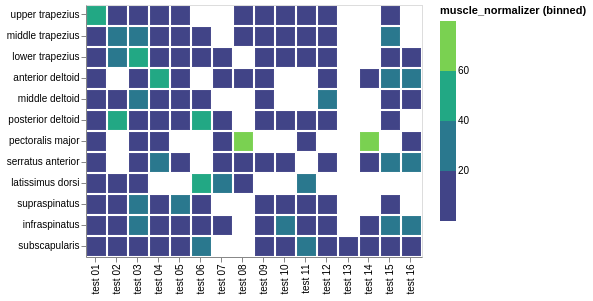

In [13]:
alt.Chart(dff).mark_rect().encode(
    alt.X("test", title=None),
    alt.Y("muscle", sort=alt.Sort(MUSCLES), title=None),
    alt.Color("muscle_normalizer", bin=True),
)

# Part 3: Machine learning pipeline

Since tests number 4, 5 and 6 have few missing data (3) and are good normalizers, we will try to predict the maximum obtained with the 16 tests from these three tests alone.

In [14]:
from sklearn.model_selection import GroupShuffleSplit

class Normalize:
    def __init__(self, ref):
        self.ref = ref

    def fit(self, X, y=None):
        self.ref_vector = X[self.ref]
        return self

    def transform(self, X):
        if isinstance(X, pd.core.series.Series):
            return X.multiply(100, axis=0).divide(self.ref_vector, axis=0)
        else:
            X = X.copy()
            num_cols = X.select_dtypes(include="float").columns
            X[num_cols] = (
                X[num_cols].multiply(100, axis=0).divide(self.ref_vector, axis=0)
            )
            return X

    def fit_transform(self, X, y=None):
        return self.fit(X).transform(X)

    def inverse_transform(self, X):
        return X.divide(100, axis=0).multiply(self.ref_vector, axis=0)


def get_X_y_p(d, cols):
    X = d[cols].dropna(subset=cols)
    y = d.select_dtypes(include="float").max(axis=1)
    p = d["participant"].iloc[X.index]

    # remove the top 2.5 percentile
    normalized_y = Normalize(ref="test 05").fit(X).transform(y)
    y = y.loc[normalized_y < normalized_y.quantile(0.975)]
    return X.loc[y.index], y, p.loc[y.index]


def split_data(X, y, p, test_size):
    # we want to make sure that all the data from one participant is in only one set
    train_id, test_id = next(
        GroupShuffleSplit(test_size=test_size, random_state=RANDOM_SEED).split(
            X, groups=p
        )
    )
    return X.iloc[train_id], X.iloc[test_id], y.iloc[train_id], y.iloc[test_id]


def mape_vector(y_true, y_pred):
    return (np.abs((y_pred - y_true) / y_true))


In [15]:
COLS_TO_KEEP = ["muscle", "test 04", "test 05", "test 06"]
TEST_SIZE = 0.2

X, y, p = get_X_y_p(df_wide, COLS_TO_KEEP)

X_train, X_test, y_train, y_test = split_data(X, y, p, test_size=0.2)

float_cols = X.select_dtypes(include="float").columns

norm_train = Normalize(ref="test 05").fit(X_train)
X_train = norm_train.transform(X_train)
y_train = norm_train.transform(y_train)

norm_test = Normalize(ref="test 05").fit(X_test)
X_test = norm_test.transform(X_test)
y_test = norm_test.transform(y_test)

In [16]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(verbose=False, random_seed=RANDOM_SEED)
model.fit(X_train, y_train, cat_features=[0])

In [17]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [18]:
train_eval = (
    mape_vector(y_train, y_pred_train)
    .rename("mape")
    .to_frame()
    .assign(muscle=X_train["muscle"], split="train")
)
test_eval = (
    mape_vector(y_test, y_pred_test)
    .rename("mape")
    .to_frame()
    .assign(muscle=X_test["muscle"], split="test")
)

eval_df = pd.concat([train_eval, test_eval])
eval_df.head()

,mape,muscle,split
0,0.108509,anterior deltoid,train
1,0.016882,latissimus dorsi,train
2,0.091399,lower trapezius,train
3,0.205286,middle deltoid,train
4,0.355257,middle trapezius,train


In [19]:
eval_df.query('split == "test"').mean()

mape    0.195016
dtype: float64

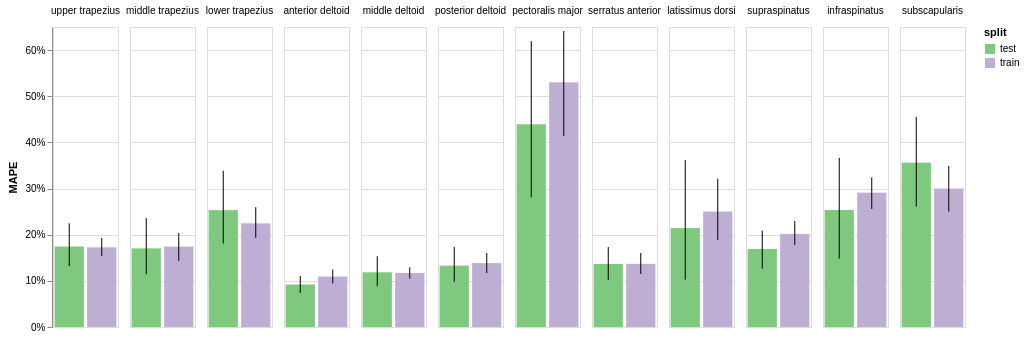

In [20]:
base = (
    alt.Chart()
    .encode(
        alt.X(
            "split",
            title=None,
            axis=alt.Axis(labels=False, domain=False, ticks=False),
            sort=["train", "test"],
        )
    )
    .properties(width=65)
)

bar = base.mark_bar().encode(
    alt.Y("mean(mape)", title="MAPE", axis=alt.Axis(format="%")), alt.Color("split", scale=alt.Scale(scheme='accent'))
)
error = base.mark_rule().encode(alt.Y("ci0(mape)"), alt.Y2("ci1(mape)"))


(bar + error).facet(data=eval_df, column=alt.Column("muscle", sort=MUSCLES, title=None))

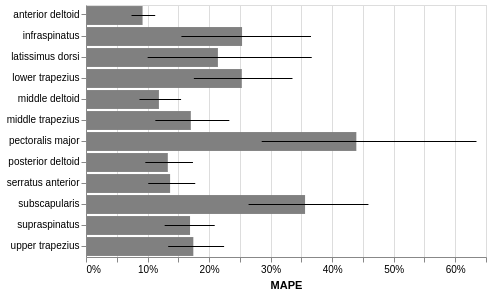

In [21]:
base = alt.Chart(test_eval).encode(alt.Y("muscle", title=None))

bar = base.mark_bar(color="grey").encode(
    alt.X("mean(mape)", axis=alt.Axis(format="%"), title="MAPE")
)
error = base.mark_rule().encode(alt.X("ci0(mape)"), alt.X2("ci1(mape)"))

bar + error

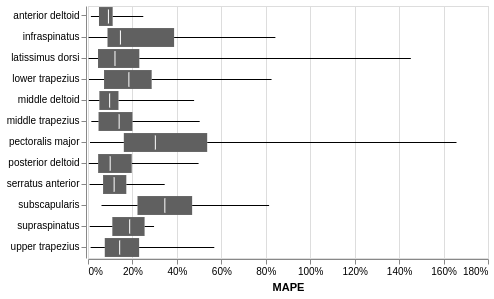

In [22]:
base = alt.Chart().encode(alt.Y("muscle", sort=MUSCLES, title=None))

bar = base.mark_bar(color="#606060").encode(
    alt.X("q1(mape)", axis=alt.Axis(format="%"), title="MAPE"), alt.X2("q3(mape)")
)
lower = base.mark_rule().encode(alt.X("min(mape)"), alt.X2("q1(mape)"))
upper = base.mark_rule().encode(alt.X("q3(mape)"), alt.X2("max(mape)"))
med = base.mark_tick(color='white').encode(alt.X("median(mape)"))

(upper + bar + med + lower).facet(data=test_eval)

In [23]:
mean_error = test_eval["mape"].mean()

error_vector = pd.DataFrame({"emg": np.linspace(0, 1, 100)}).assign(
    error=lambda x: x["emg"] * mean_error,
    error_upper=lambda x: x["emg"] + x["emg"] * mean_error,
    error_lower=lambda x: x["emg"] - x["emg"] * mean_error,
)

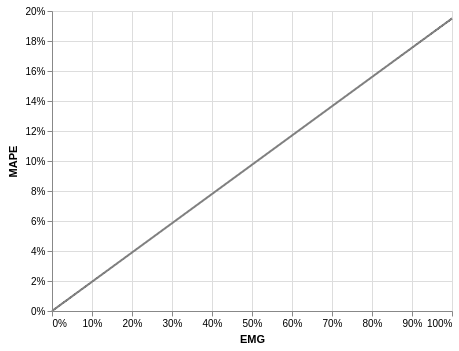

In [24]:
alt.Chart(error_vector).mark_line(color="grey").encode(
    alt.X("emg", axis=alt.Axis(format="%"), title='EMG'),
    alt.Y("error", title="MAPE", axis=alt.Axis(format="%")),
)

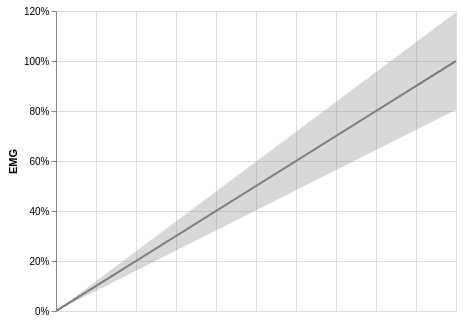

In [25]:
line = (
    alt.Chart(error_vector)
    .mark_line(color="grey")
    .encode(
        alt.X(
            "emg", title=None, axis=alt.Axis(labels=False, domain=False, ticks=False)
        ),
        alt.Y("emg", title="EMG", axis=alt.Axis(format="%")),
    )
)
area = (
    alt.Chart(error_vector)
    .mark_area(color="grey", opacity=0.3)
    .encode(alt.X("emg"), alt.Y("error_lower"), alt.Y2("error_upper"))
)
line + area

In [26]:
import pymc3 as pm

In [27]:
from scipy.stats import gaussian_kde


def min_max_scaler(x, pad):
    x_min = x.min() + x.min() * pad if pad else x.min()
    x_max = x.max() + x.max() * pad if pad else x.max()
    return (x - x_min) / (x_max - x_min)


def compute_kde(x, n_points=100, pad=0.1, mini=None, maxi=None, normalize=True):
    x = x.dropna().copy()
    x_min = mini if mini else x.min() - x.min() * pad
    x_max = maxi if maxi else x.max() + x.max() * pad
    x_grid = np.linspace(x_min, x_max, n_points)

    if normalize:
        kde = min_max_scaler(gaussian_kde(x)(x_grid), pad=0.2)
    else:
        gaussian_kde(x)(x_grid)

    return pd.DataFrame({"value": x_grid, "kde": kde})

In [28]:
def bayes_summary(trace, ref, alpha=0.05):
    d = (
        pm.trace_to_dataframe(trace)
        if isinstance(trace, pm.backends.base.MultiTrace)
        else trace
    )
    return (
        pd.DataFrame(
            {
                "mean": d.mean(),
                "std_lower": d.mean() - d.std(),
                "std_upper": d.mean() + d.std(),
                f"proba < {ref}": (d < ref).sum() / d.notnull().sum() * 100,
                f"proba > {ref}": (d > ref).sum() / d.notnull().sum() * 100,
            }
        )
        .join(
            pd.DataFrame(
                [pm.hpd(d[i].dropna(), alpha=alpha) for i in d],
                columns=["hpd_lower", "hpd_upper"],
                index=d.columns,
            )
        )
        .assign(
            **{
                f"{ref} outside HPD": lambda x: (x.filter(like="hpd") > ref).all(axis=1)
                | (x.filter(like="hpd") < ref).all(axis=1)
            }
        )
    )

In [29]:
def plot_bayes_violin(trace, ref, domain, xlabel, alpha=0.05, height=None):
    # get summary and assign y coordinates
    summary = (
        bayes_summary(trace, ref, alpha)
        .assign(y_plot=lambda x: np.arange(0, x.shape[0], 1))
        .reset_index()
    )

    # compute kde
    kdes = (
        pd.concat(
            [
                compute_kde(
                    trace[i].dropna().reset_index(drop=True), n_points=100, pad=0.1
                ).assign(index=i)
                for i in trace
            ]
        )
        .merge(summary[["index", "y_plot", f"{ref} outside HPD"]], on="index")
        .assign(kde=lambda x: x["kde"] + x["y_plot"])
    )

    # make chart
    color_scale = alt.Scale(domain=[True, False], range=["#252525", "#737373"])
    base = alt.Chart().encode(
        alt.Y("y_plot"),
        alt.Color(f"{ref} outside HPD", scale=color_scale),
        alt.Tooltip(["index:N", "mean:Q", "hpd_lower:Q", "hpd_upper:Q"]),
    )

    points = base.mark_circle(size=200).encode(
        alt.X("mean", title=xlabel, axis=alt.Axis(format="%"))
    )

    rules_hpd = base.mark_rule(size=4).encode(
        alt.X("hpd_lower", scale=alt.Scale(domain=domain, clamp=True)),
        alt.X2("hpd_upper"),
    )

    rule = (
        alt.Chart(pd.DataFrame({"ref": ref}, index=[0]))
        .mark_rule(color="grey", strokeWidth=2)
        .encode(alt.X("ref"))
    )

    y_labels = (
        alt.Chart()
        .mark_text(dx=-205, align="right")
        .encode(alt.Y("y_plot"), alt.Text("index"))
    )

    k = (
        alt.Chart(kdes)
        .mark_area(opacity=0.7, clip=True)
        .encode(
            alt.X("value", scale=alt.Scale(domain=domain, clamp=True)),
            alt.Y(
                "kde",
                axis=alt.Axis(labels=False, ticks=False, domain=False, grid=False),
                scale=alt.Scale(domain=[0, summary.shape[0]]),
                title=None,
            ),
            alt.Y2("y_plot"),
            alt.Detail("index"),
            alt.Color(f"{ref} outside HPD", scale=color_scale),
        )
    )
    rule = rule.properties(height=height) if height else rule
    return (rule + rules_hpd + points + k + y_labels).facet(data=summary)

In [30]:
x = (
    test_eval.drop("split", axis=1)
    .rename(columns={'muscle': 'index'})
    .pivot(columns="index")
    .droplevel(level=0, axis=1)
)[MUSCLES]
x.head()

index,upper trapezius,middle trapezius,lower trapezius,anterior deltoid,middle deltoid,posterior deltoid,pectoralis major,serratus anterior,latissimus dorsi,supraspinatus,infraspinatus,subscapularis
8,NaN,NaN,NaN,0.058858,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.097979,NaN,NaN,NaN
10,NaN,NaN,0.248953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,NaN,NaN,NaN,NaN,0.00357,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12,NaN,0.434778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [31]:
bayes_summary(x, ref=0.1)

,mean,std_lower,std_upper,proba < 0.1,proba > 0.1,hpd_lower,hpd_upper,0.1 outside HPD
index,,,,,,,,
upper trapezius,0.174401,0.035276,0.313526,40.000000,60.000000,0.011756,0.462883,False
middle trapezius,0.170318,0.022404,0.318231,39.130435,60.869565,0.015048,0.460624,False
lower trapezius,0.253177,0.010533,0.495821,30.303030,69.696970,0.004424,0.762947,False
anterior deltoid,0.091919,0.037173,0.146665,64.516129,35.483871,0.013119,0.196753,False
middle deltoid,0.118483,0.014633,0.222333,51.351351,48.648649,0.003570,0.343820,False
posterior deltoid,0.132933,0.018629,0.247236,51.351351,48.648649,0.003681,0.389161,False
pectoralis major,0.439285,0.003858,0.874711,13.636364,86.363636,0.009014,1.518838,False
serratus anterior,0.136651,0.040023,0.233279,44.000000,56.000000,0.007066,0.304492,False
latissimus dorsi,0.214338,-0.128626,0.557301,48.000000,52.000000,0.002636,1.125259,False


In [32]:
test_eval.head()

,mape,muscle,split
8,0.058858,anterior deltoid,test
9,0.097979,latissimus dorsi,test
10,0.248953,lower trapezius,test
11,0.003570,middle deltoid,test
12,0.434778,middle trapezius,test


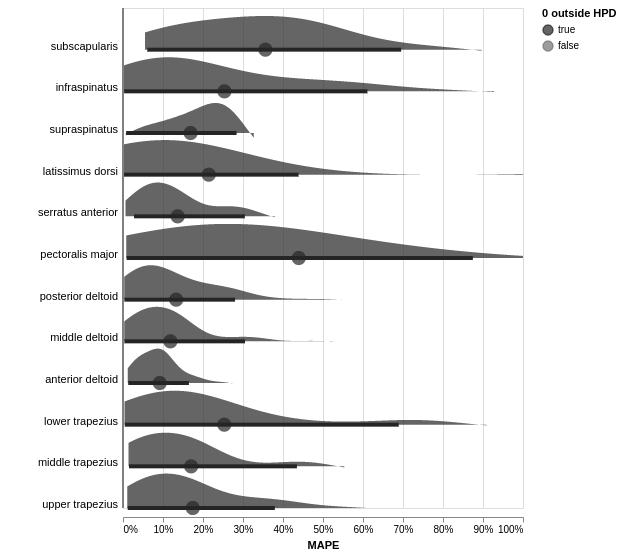

In [33]:
plot_bayes_violin(x, ref=0, domain=[0, 1], xlabel="MAPE", alpha=0.1, height=500)

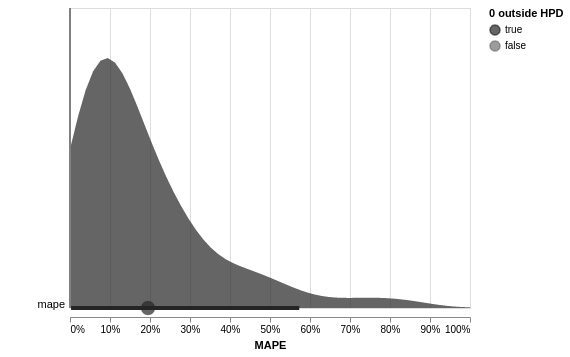

In [34]:
plot_bayes_violin(test_eval[['mape']], ref=0, domain=[0, 1], xlabel='MAPE')

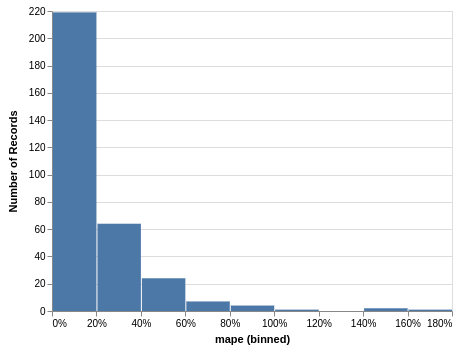

In [35]:
alt.Chart(test_eval).mark_bar().encode(
    alt.Y("count()"),
    alt.X("mape", bin=alt.Bin(maxbins=10), axis=alt.Axis(format="%")),
#     alt.Row("muscle"),
)

# Part 4: Comparison with other studies

In [36]:
import pickle

RECOMMANDATIONS_PATH = MODEL_PATH / "recommandations.pkl"
if RECOMMANDATIONS_PATH.is_file():
    with open(RECOMMANDATIONS_PATH, "rb") as h:
        recommandations = pickle.load(h)
else:
    recommandations = {}

## Boettcher et al., 2008

[Boettcher et al., 2008](https://onlinelibrary.wiley.com/doi/abs/10.1002/jor.20675) identified a unique combinations of 4 MVIC tests to normalize 12 shoulder muscles

In [37]:
if not RECOMMANDATIONS_PATH.is_file():
    recommandations["NT4"] = {
        i: ["test 12", "test 13", "test 14", "test 15"] for i in MUSCLES
    }

## Dal Maso et al., 2016

[Dal Maso et al., 2016](https://www.sciencedirect.com/science/article/pii/S0003999316000307)

### As published

In [38]:
if not RECOMMANDATIONS_PATH.is_file():
    recommandations["DM"] = {
        "upper trapezius": ["test 01", "test 03", "test 05", "test 12"],
        "middle trapezius": [
            "test 02",
            "test 03",
            "test 08",
            "test 10",
            "test 12",
            "test 15",
        ],
        "lower trapezius": ["test 02", "test 03", "test 05", "test 11", "test 15"],
        "anterior deltoid": ["test 04", "test 05", "test 09", "test 12"],
        "middle deltoid": ["test 03", "test 09", "test 12", "test 15"],
        "posterior deltoid": ["test 02", "test 06"],
        "pectoralis major": ["test 08", "test 14"],
        "serratus anterior": ["test 03", "test 05", "test 07", "test 14", "test 15"],
        "latissimus dorsi": ["test 06", "test 07", "test 08", "test 11"],
        "supraspinatus": ["test 01", "test 03", "test 05", "test 12"],
        "infraspinatus": ["test 02", "test 03", "test 04", "test 15"],
        "subscapularis": [
            "test 02",
            "test 03",
            "test 06",
            "test 10",
            "test 11",
            "test 15",
        ],
    }

### Implemented on our data

In [39]:
def compute_criterion(d, sets, thr):
    proportion = np.ones((sets.shape[0]))
    for i, iset in enumerate(sets):
        maximal_above_thr = d[iset].max(axis=1) > d.max(axis=1) * (thr / 100)
        proportion[i] = maximal_above_thr.sum() / d.shape[0] * 100

    sorted_idx = np.argsort(proportion)
    best_set = sets[sorted_idx][-1]
    best_proportion = proportion[sorted_idx][-1]
    return best_set, best_proportion

In [40]:
from itertools import combinations

THRESHOLD = 90
PERCENTILE = 90
TESTS = [i for i in df_wide.columns if i[:4] == "test"]

if RECOMMANDATIONS_PATH.is_file():
    print(recommandations["DM updated"])
else:
    recommandations["DM updated"] = {}
    for imuscle in MUSCLES:
        X_train_comp = df_wide.loc[X_train.index].query("muscle == @imuscle")[TESTS]
        print(f"{imuscle.upper()} ({X_train_comp.shape[0]} points)")

        for ntests in range(1, len(TESTS) + 1):
            sets = np.array(list(combinations(TESTS, ntests)))
            best_set, best_proportion = compute_criterion(X_train_comp, sets, thr=THRESHOLD)

            if best_proportion > PERCENTILE:
                print(f"\tno. of tests: {ntests}")
                print(f"\tbest set: {best_set}")
                print(f"\tproportion: {best_proportion:.2f}")
                print("-" * 10)
                recommandations["DM updated"][imuscle] = best_set
                break
    with open(RECOMMANDATIONS_PATH, "wb") as h:
        pickle.dump(recommandations, h)

{'upper trapezius': array(['test 01', 'test 03', 'test 05'], dtype='<U7'), 'middle trapezius': array(['test 02', 'test 03', 'test 05', 'test 09', 'test 10', 'test 15'],
      dtype='<U7'), 'lower trapezius': array(['test 02', 'test 03', 'test 04', 'test 06', 'test 15'], dtype='<U7'), 'anterior deltoid': array(['test 03', 'test 04', 'test 05', 'test 09', 'test 15', 'test 16'],
      dtype='<U7'), 'middle deltoid': array(['test 01', 'test 03', 'test 04', 'test 05', 'test 15'], dtype='<U7'), 'posterior deltoid': array(['test 02', 'test 03', 'test 06'], dtype='<U7'), 'pectoralis major': array(['test 08', 'test 14'], dtype='<U7'), 'serratus anterior': array(['test 01', 'test 03', 'test 04', 'test 05', 'test 15'], dtype='<U7'), 'latissimus dorsi': array(['test 06', 'test 07', 'test 11'], dtype='<U7'), 'supraspinatus': array(['test 01', 'test 03', 'test 04', 'test 05', 'test 09'], dtype='<U7'), 'infraspinatus': array(['test 03', 'test 04', 'test 06', 'test 10', 'test 11', 'test 15'],
      dt

## Compare Boettcher & Dal Maso with our model

### MAPE for each method

In [41]:
recommandations["B-4"] = recommandations.pop("NT4")
recommandations["DM-14"] = recommandations.pop("DM")
recommandations.pop('DM updated', None);

In [42]:
recommandations.keys()

dict_keys(['B-4', 'DM-14'])

In [43]:
test_comparison = df_wide.drop(["dataset", "participant"], axis=1).loc[X_test.index]

r = []
for imuscle in MUSCLES:
    current = test_comparison.query("muscle == @imuscle").drop("muscle", axis=1)
    for imethod in recommandations.keys():
        r.append(
            mape_vector(
                current.max(axis=1),
                current[recommandations[imethod][imuscle]].max(axis=1),
            )
            .rename("mape")
            .to_frame()
            .assign(method=imethod, muscle=imuscle)
        )

df_comp = pd.concat(
    r + [test_eval.drop("split", axis=1).assign(method="P-3")], sort=False
)

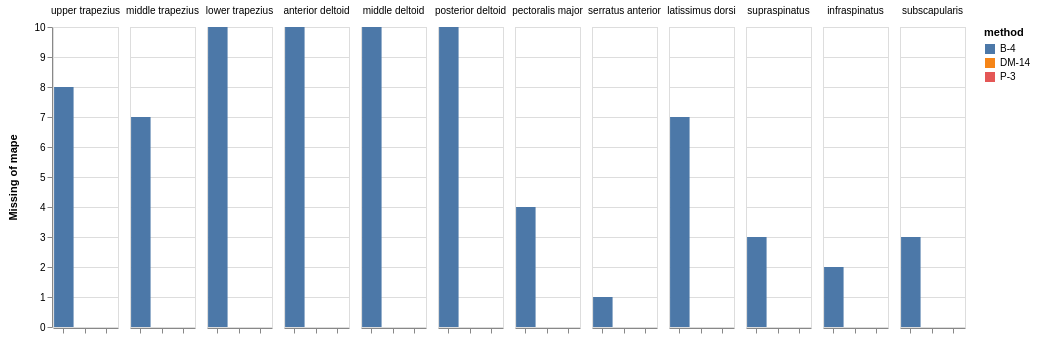

In [44]:
alt.Chart(df_comp).mark_bar().encode(
    alt.X("method", axis=alt.Axis(title="", labels=False)),
    alt.Y("missing(mape)"),
    alt.Color("method"),
    alt.Column("muscle", sort=MUSCLES, title=None),
).properties(width=65)

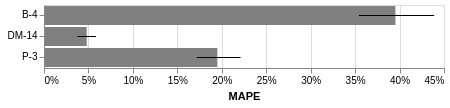

In [45]:
base = alt.Chart(df_comp).encode(alt.Y("method", title=None))

bar = base.mark_bar(color="grey").encode(
    alt.X("mean(mape)", axis=alt.Axis(format="%"), title="MAPE")
)
error = base.mark_rule().encode(alt.X("ci0(mape)"), alt.X2("ci1(mape)"))

bar + error

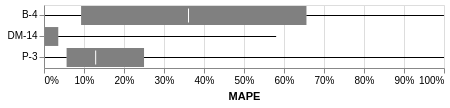

In [46]:
base = alt.Chart(df_comp).encode(alt.Y("method", title=None))

bar = base.mark_bar(color="grey").encode(
    alt.X("q1(mape)", axis=alt.Axis(format="%"), title="MAPE"), alt.X2("q3(mape)")
)
med = base.mark_tick(color="white").encode(alt.X("median(mape)"))
upper = base.mark_rule().encode(
    alt.X("q3(mape)", scale=alt.Scale(domain=[0, 1], clamp=True)), alt.X2("max(mape)")
)
lower = base.mark_rule().encode(alt.X("min(mape)"), alt.X2("q1(mape)"))


bar + med + upper + lower

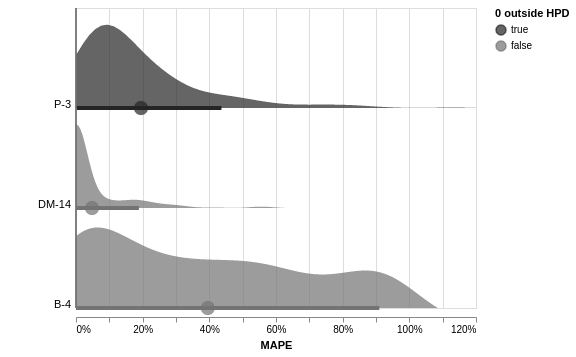

In [47]:
comp_wide = (
    df_comp.drop("muscle", axis=1)
    .rename(columns={"method": "index"})
    .pivot(columns="index")
    .droplevel(level=0, axis=1)
)

plot_bayes_violin(comp_wide, ref=0, domain=[0, 1.2], xlabel="MAPE", alpha=0.1)

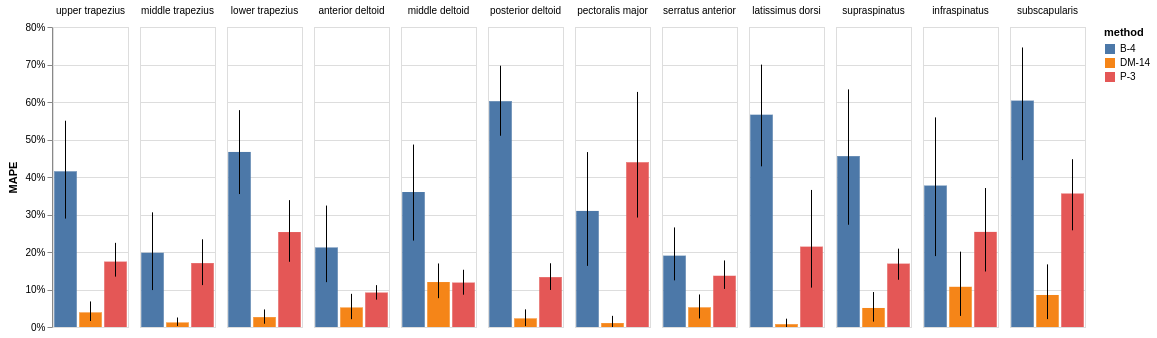

In [48]:
base = alt.Chart().encode(
    alt.X("method", axis=alt.Axis(title="", labels=False, ticks=False, domain=False))
)


bar = base.mark_bar().encode(
    alt.Y("mean(mape)", axis=alt.Axis(format="%"), title="MAPE"), alt.Color("method")
)
error = base.mark_rule().encode(alt.Y("ci0(mape)"), alt.Y2("ci1(mape)"))

(bar.properties(width=75) + error).facet(data=df_comp, column=alt.Column("muscle", sort=MUSCLES, title=None))

### Compare execution time

In [49]:
time_by_test = 4  # min
time = {}
for imethod in recommandations.keys():
    c = []
    for imuscle, tests in recommandations[imethod].items():
        for itest in tests:
            if itest not in c:
                c.append(itest)
    time[imethod] = time_by_test * len(c)
time["P-3"] = time_by_test * 3
time = pd.Series(time).rename("Execution time (min)").rename_axis("method").reset_index()

In [50]:
time

,method,Execution time (min)
0,B-4,16
1,DM-14,56
2,P-3,12


In [51]:
(df_comp.groupby('method').agg(['mean', 'std']) * 100).round(2)

mape       
         mean    std
method              
B-4     39.53  32.93
DM-14    4.81  10.40
P-3     19.50  22.07

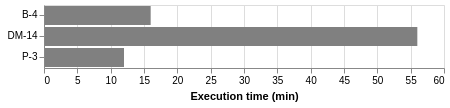

In [52]:
alt.Chart(time).mark_bar(color="grey").encode(
    alt.X("Execution time (min)"),
    alt.Y("method", title=None),
    alt.Tooltip("Execution time (min)"),
)

In [53]:
scatter_df = (
    df_comp.groupby("method")["mape"].mean().reset_index().merge(time, on="method")
).assign(
    dist_from_0=lambda x: np.sqrt(
        (x["mape"].multiply(100).pow(2) + x["Execution time (min)"].pow(2))
    ).round(2)
)

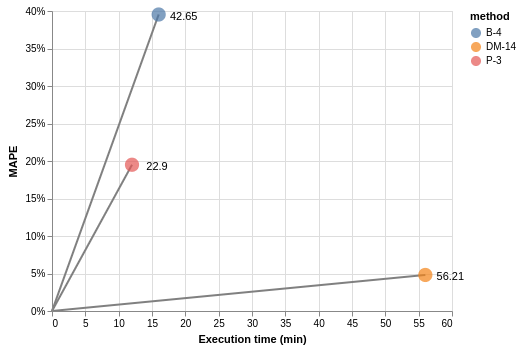

In [54]:
scatter = (
    alt.Chart(scatter_df)
    .mark_circle(size=200)
    .encode(
        alt.X("Execution time (min)", scale=alt.Scale()), alt.Y("mape", title="MAPE", axis=alt.Axis(format='%')), alt.Color("method")
    )
)

text = (
    alt.Chart(scatter_df)
    .mark_text(dx=25, dy=5)
    .encode(
        alt.X("Execution time (min)"), alt.Y("mape"), alt.Text('dist_from_0')
    )
)

dist_rule = (
    alt.Chart(
        pd.concat(
            [scatter_df, scatter_df.assign(**{"mape": 0, "Execution time (min)": 0})]
        )
    )
    .mark_line(color='grey')
    .encode(alt.X("Execution time (min)"), alt.Y("mape"), alt.Detail("method"))
)

dist_rule + scatter + text

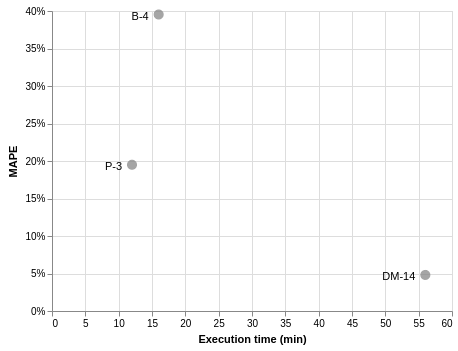

In [55]:
base = alt.Chart(scatter_df).encode(
    alt.X("Execution time (min)"),
    alt.Y("mape", title="MAPE", axis=alt.Axis(format="%")),
)

base.mark_circle(color='grey', size=100) + base.mark_text(dx=-10, dy=5, align='right').encode(alt.Text('method'))

In [56]:
def percentage_below_percentage(x, perc=0.1):
    return (x.dropna() < perc).sum() / x.dropna().shape[0] * 100

In [57]:
df_comp.groupby('method')['mape'].apply(percentage_below_percentage)

method
B-4      26.315789
DM-14    81.677019
P-3      40.372671
Name: mape, dtype: float64

---

### Hierarchical models

Several statistical inference procedures involve the comparison of two groups. We may be interested in whether one group is larger than another, or simply different from the other.

Unfortunately, it is not easy to conduct hypothesis tests correctly, and their results are very easy to misinterpret. Setting up a statistical test involves several subjective choices (e.g. statistical test to use, null hypothesis to test, significance level) by the user that are rarely justified based on the problem or decision at hand, but rather, are usually based on traditional choices that are entirely arbitrary (Johnson 1999). The evidence that it provides to the user is indirect, incomplete, and typically overstates the evidence against the null hypothesis (Goodman 1999).

A more informative and effective approach for comparing groups is one based on __estimation__ rather than testing, and is driven by Bayesian probability rather than frequentist. That is, rather than testing whether two groups are different, we instead pursue an estimate of how different they are, which is fundamentally more informative. Moreover, we include an estimate of uncertainty associated with that difference which includes uncertainty due to our lack of knowledge of the model parameters (epistemic uncertainty) and uncertainty due to the inherent stochasticity of the system (aleatory uncertainty).

In [58]:
def best(dct):
    df = pd.concat([pd.DataFrame({'group': group, 'value': value}) for group, value in dct.items()])
    a, b = dct.keys()
    
    μ_m = df['value'].mean()
    μ_s = df['value'].std() * 2

    σ_low = 0.1
    σ_high = 1
    
    print(df.query('group == @a')['value'].std())
    
    with pm.Model() as model:
        a_mean = pm.Normal(f"{a}_mean", mu=μ_m, sd=μ_s)
        b_mean = pm.Normal(f"{b}_mean", mu=μ_m, sd=μ_s)

        a_std = pm.Uniform(f"{a}_std", lower=σ_low, upper=σ_high)
        b_std = pm.Uniform(f"{b}_std", lower=σ_low, upper=σ_high)

        ν = pm.Exponential("ν_minus_one", lam=1 / 29.0) + 1

        λ1 = a_std ** -2
        λ2 = b_std ** -2

        # T distribution is less sensitive to outlier observations, relative to a normal distribution
        group1 = pm.StudentT(a, nu=ν, mu=a_mean, lam=λ1, observed=df.query('group == @a')['value'])
        group2 = pm.StudentT(b, nu=ν, mu=b_mean, lam=λ2, observed=df.query('group == @b')['value'])

        diff_of_means = pm.Deterministic("difference of means", a_mean - b_mean)
        diff_of_stds = pm.Deterministic("difference of stds", a_std - b_std)
        effect_size = pm.Deterministic(
            "effect size", diff_of_means / np.sqrt((a_std ** 2 + b_std ** 2) / 2)
        )
        
    return model

0.08290997207763111


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, P-3_std, B-4_std, P-3_mean, B-4_mean]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2292.63draws/s]


	upper trapezius: LOWER


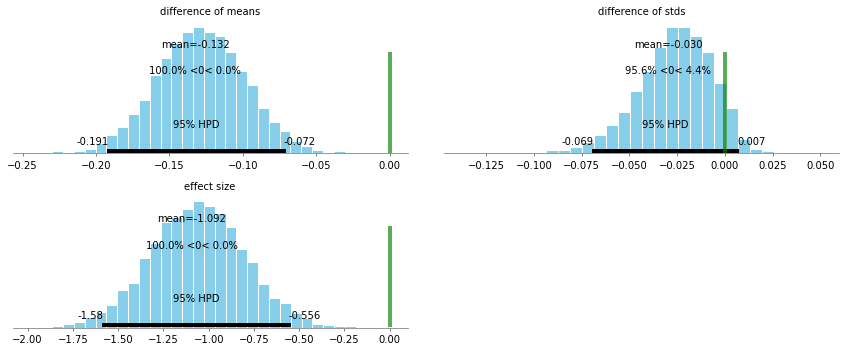

----------
0.028227271183212596


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, P-3_std, B-4_std, P-3_mean, B-4_mean]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2328.15draws/s]


	middle trapezius: LOWER


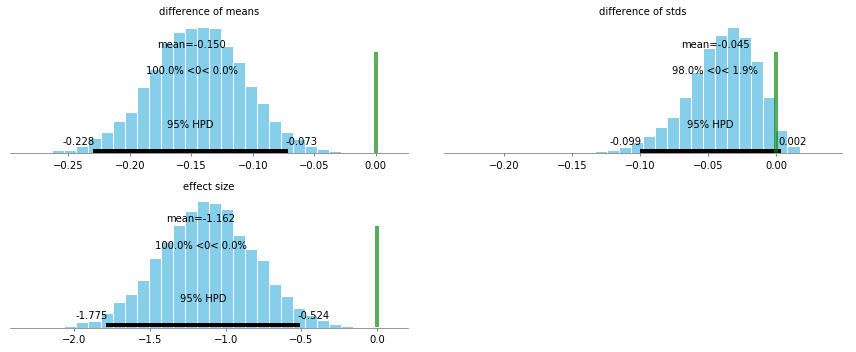

----------
0.05993677766935829


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, P-3_std, B-4_std, P-3_mean, B-4_mean]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2295.96draws/s]


	lower trapezius: LOWER


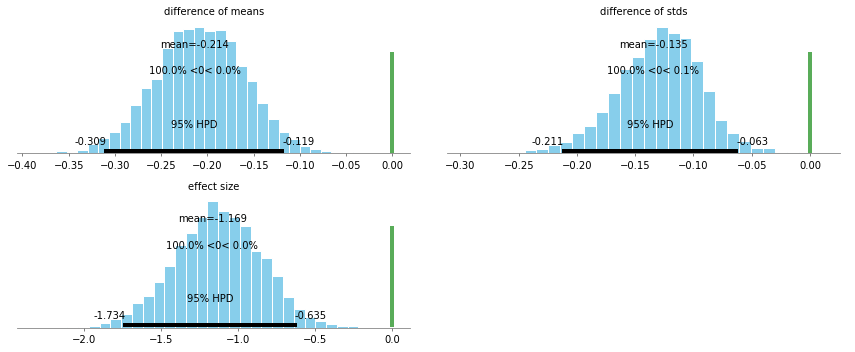

----------
0.09495456545907524


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, P-3_std, B-4_std, P-3_mean, B-4_mean]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2259.62draws/s]


	anterior deltoid: NONE


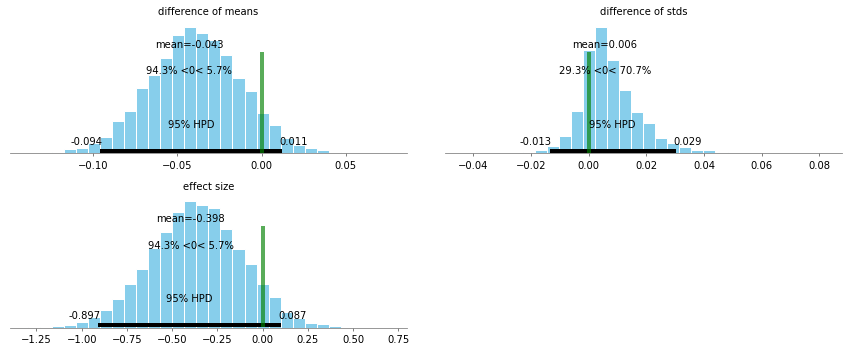

----------
0.14792863133963852


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, P-3_std, B-4_std, P-3_mean, B-4_mean]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2256.47draws/s]


	middle deltoid: NONE


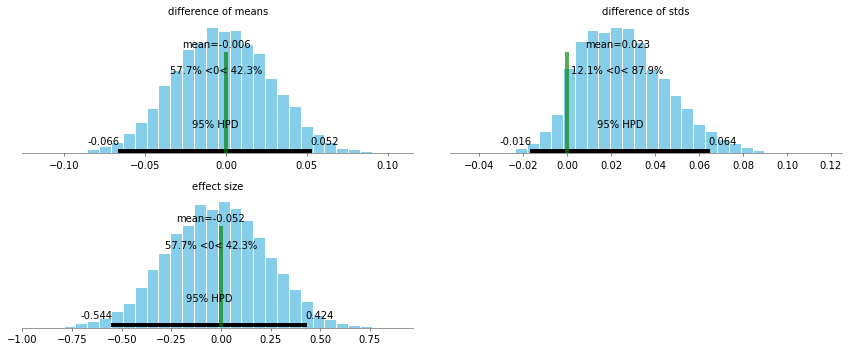

----------
0.07050000688425291


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, P-3_std, B-4_std, P-3_mean, B-4_mean]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2259.21draws/s]


	posterior deltoid: LOWER


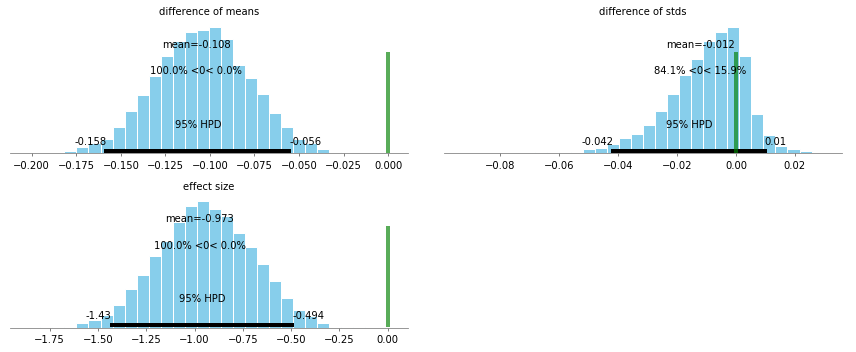

----------
0.04237932276346608


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, P-3_std, B-4_std, P-3_mean, B-4_mean]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2200.97draws/s]


	pectoralis major: LOWER


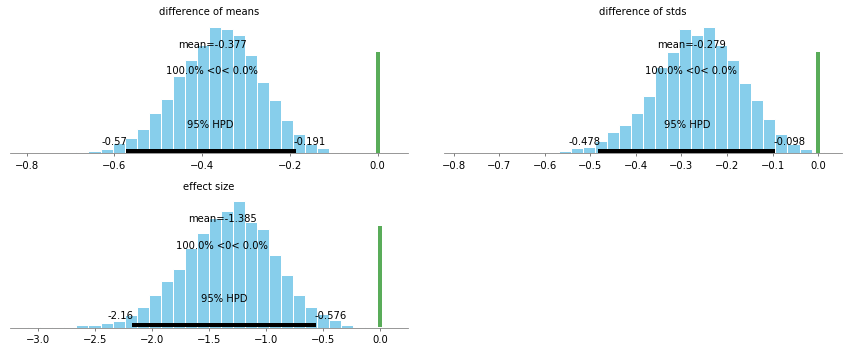

----------
0.08684534311164929


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, P-3_std, B-4_std, P-3_mean, B-4_mean]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2358.70draws/s]
The acceptance probability does not match the target. It is 0.8913912170126249, but should be close to 0.8. Try to increase the number of tuning steps.


	serratus anterior: LOWER


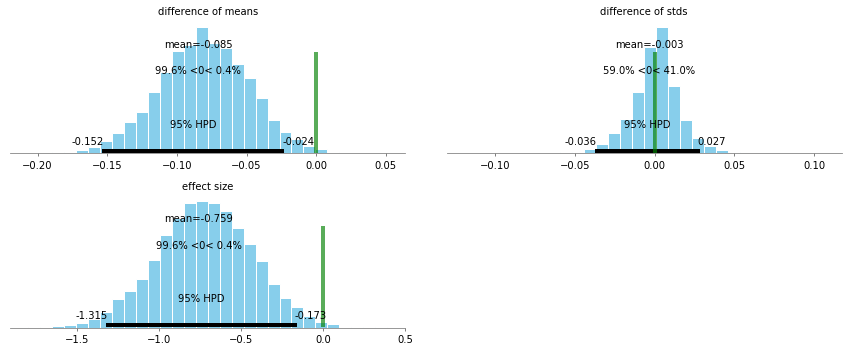

----------
0.036965215805145175


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, P-3_std, B-4_std, P-3_mean, B-4_mean]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2326.54draws/s]
The acceptance probability does not match the target. It is 0.6440880097264987, but should be close to 0.8. Try to increase the number of tuning steps.


	latissimus dorsi: LOWER


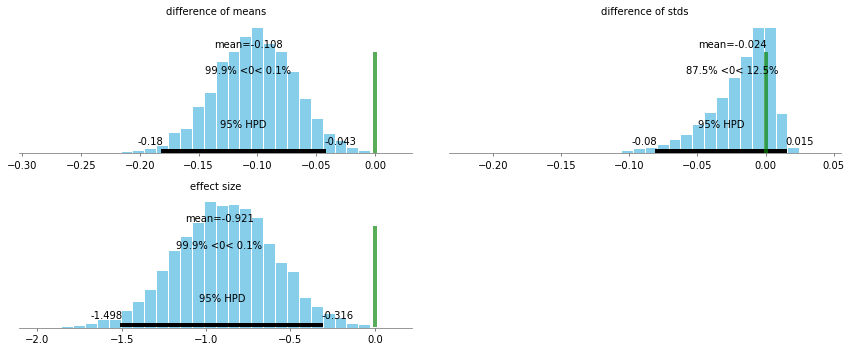

----------
0.08961554579374953


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, P-3_std, B-4_std, P-3_mean, B-4_mean]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2388.92draws/s]


	supraspinatus: LOWER


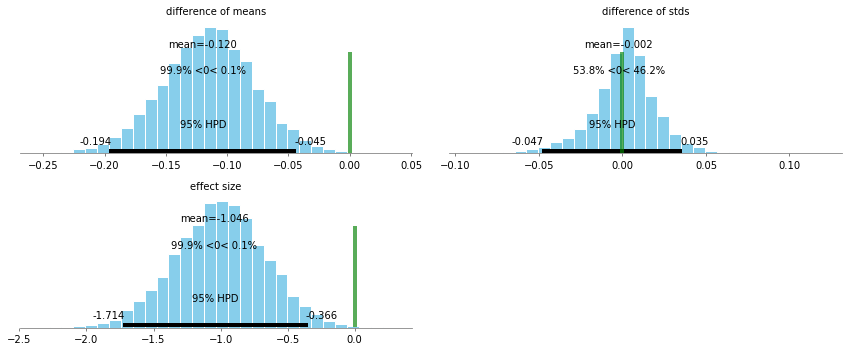

----------
0.195917559632762


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, P-3_std, B-4_std, P-3_mean, B-4_mean]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2245.46draws/s]
The acceptance probability does not match the target. It is 0.8903521967454945, but should be close to 0.8. Try to increase the number of tuning steps.


	infraspinatus: LOWER


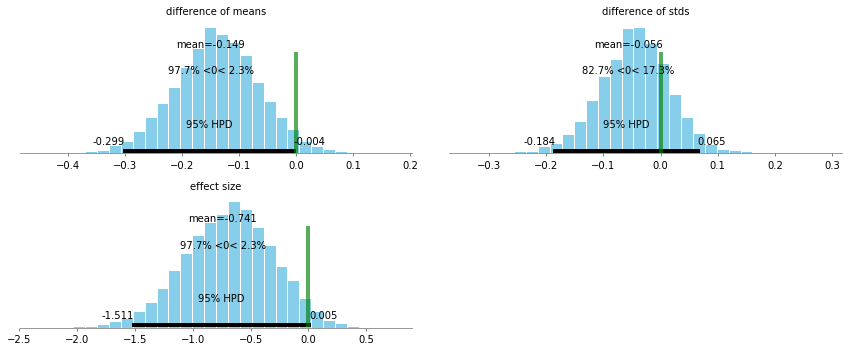

----------
0.15734884574624308


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, P-3_std, B-4_std, P-3_mean, B-4_mean]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2451.05draws/s]


	subscapularis: LOWER


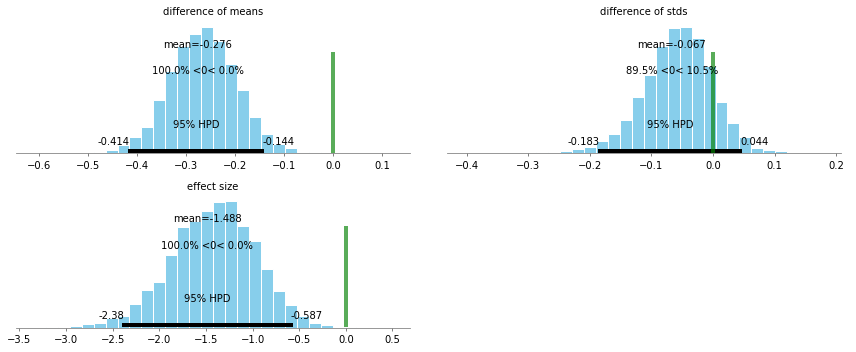

----------


In [59]:
import matplotlib.pyplot as plt

for imuscle in MUSCLES:
    d = {'B-4': df_comp.query('method == "DM-14" & muscle == @imuscle')['mape'].dropna(), 'P-3': df_comp.query('method == "P-3" & muscle == @imuscle')['mape'].dropna()}
    m = best(d)
    with m:
        trace = pm.sample(2000, tune=2000)
        
    hpd = pm.summary(trace).loc['difference of means'].filter(like='hpd')

    if (hpd > 0).all():
        print(f'\t{imuscle}: HIGHER')
    elif (hpd < 0).all():
        print(f'\t{imuscle}: LOWER')
    else:
        print(f'\t{imuscle}: NONE')
        
    pm.plot_posterior(trace, varnames=['difference of means','difference of stds', 'effect size'], ref_val=0, alpha_level=0.05)
    plt.show()
    print(f'{"-" * 10}')

0.08290997207763111


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, P-3_std, B-4_std, P-3_mean, B-4_mean]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2058.23draws/s]


	upper trapezius: LOWER


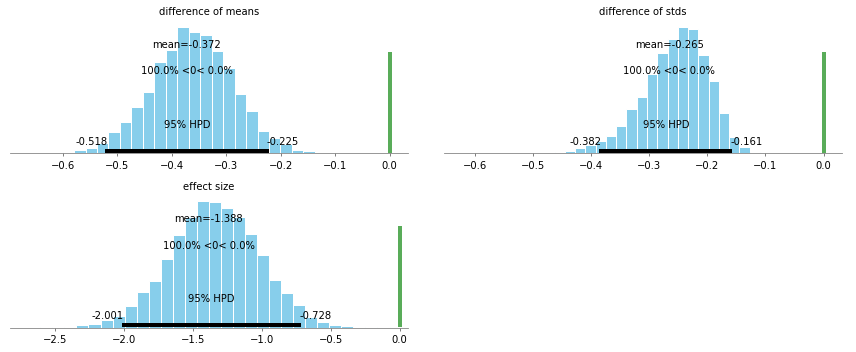

----------
0.028227271183212596


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, P-3_std, B-4_std, P-3_mean, B-4_mean]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2004.28draws/s]
The acceptance probability does not match the target. It is 0.6990130623569443, but should be close to 0.8. Try to increase the number of tuning steps.


	middle trapezius: LOWER


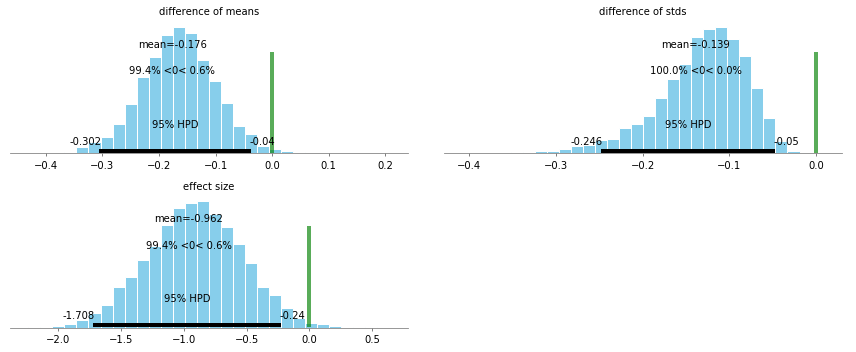

----------
0.05993677766935829


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, P-3_std, B-4_std, P-3_mean, B-4_mean]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2203.96draws/s]


	lower trapezius: LOWER


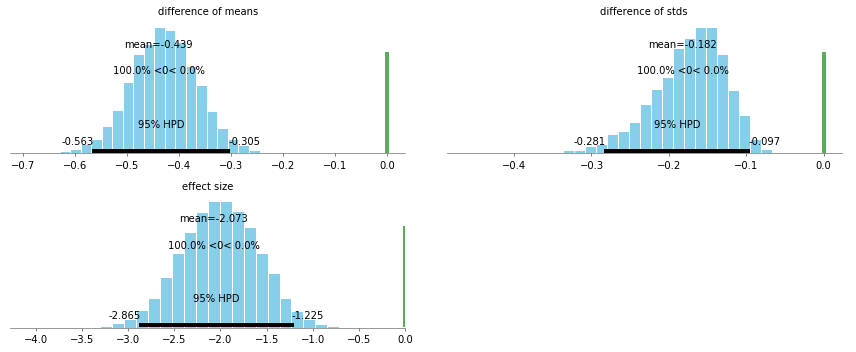

----------
0.09495456545907524


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, P-3_std, B-4_std, P-3_mean, B-4_mean]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2314.90draws/s]


	anterior deltoid: LOWER


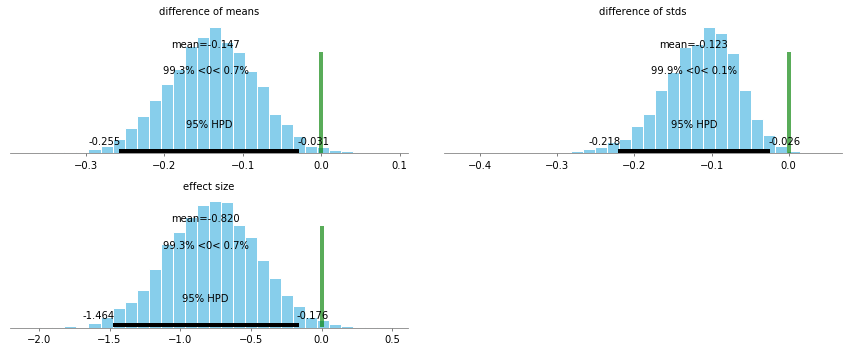

----------
0.14792863133963852


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, P-3_std, B-4_std, P-3_mean, B-4_mean]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2235.76draws/s]
The acceptance probability does not match the target. It is 0.7044407546059007, but should be close to 0.8. Try to increase the number of tuning steps.


	middle deltoid: LOWER


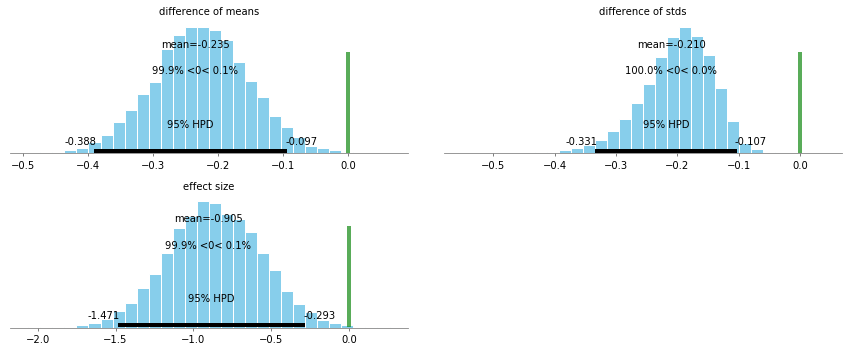

----------
0.07050000688425291


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, P-3_std, B-4_std, P-3_mean, B-4_mean]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2129.96draws/s]
The acceptance probability does not match the target. It is 0.7119664732232216, but should be close to 0.8. Try to increase the number of tuning steps.


	posterior deltoid: LOWER


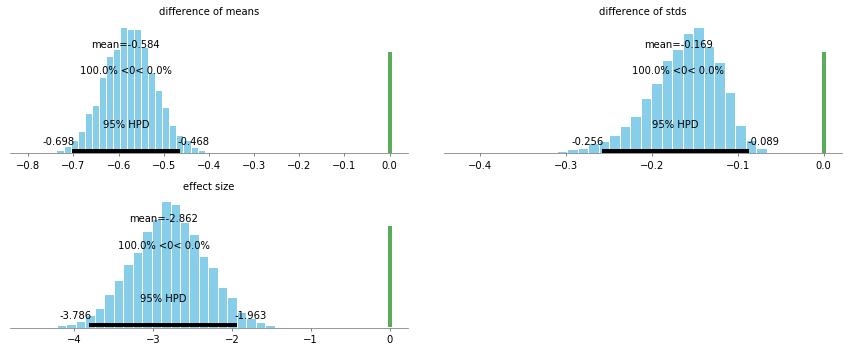

----------
0.04237932276346608


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, P-3_std, B-4_std, P-3_mean, B-4_mean]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2244.15draws/s]


	pectoralis major: LOWER


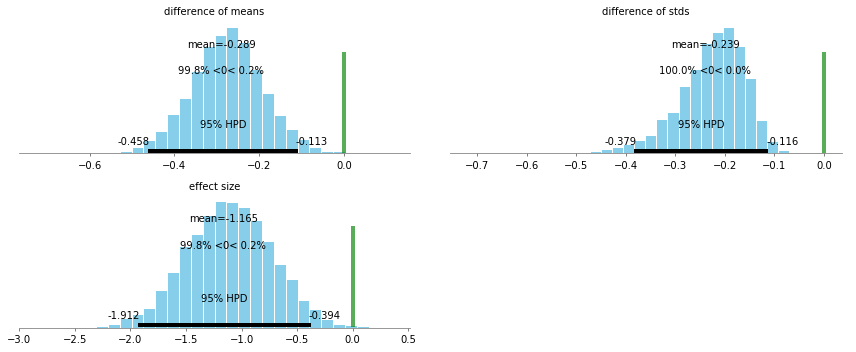

----------
0.08684534311164929


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, P-3_std, B-4_std, P-3_mean, B-4_mean]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2187.58draws/s]


	serratus anterior: LOWER


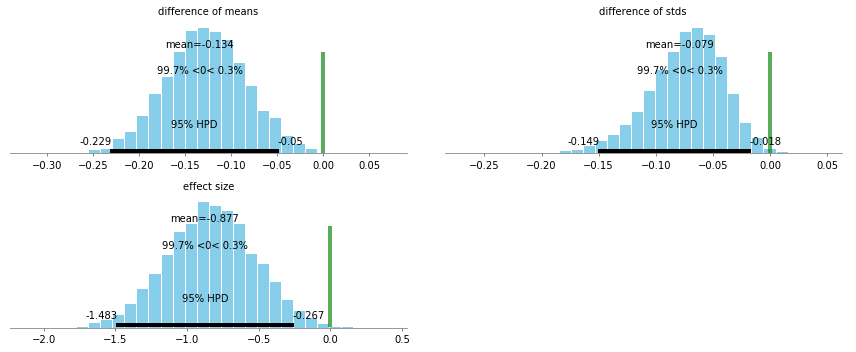

----------
0.036965215805145175


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, P-3_std, B-4_std, P-3_mean, B-4_mean]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2065.15draws/s]


	latissimus dorsi: LOWER


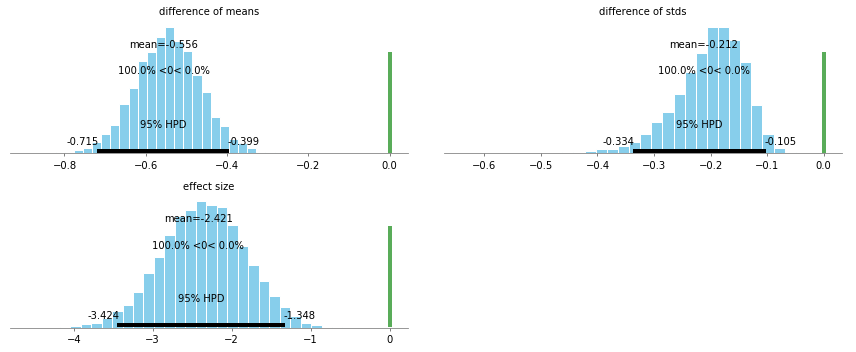

----------
0.08961554579374953


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, P-3_std, B-4_std, P-3_mean, B-4_mean]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2157.80draws/s]


	supraspinatus: LOWER


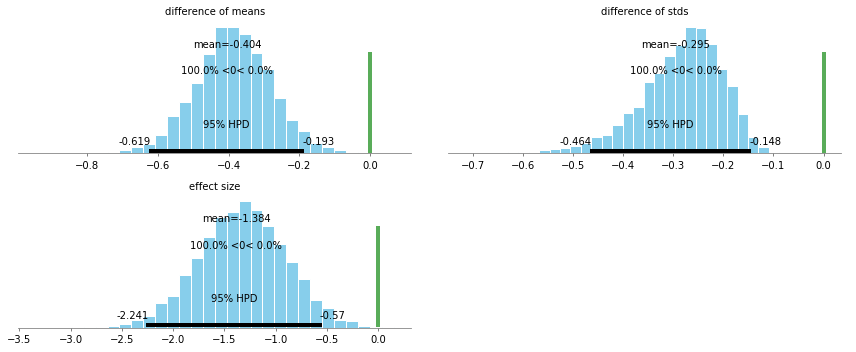

----------
0.195917559632762


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, P-3_std, B-4_std, P-3_mean, B-4_mean]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2409.99draws/s]
The acceptance probability does not match the target. It is 0.7173672125776716, but should be close to 0.8. Try to increase the number of tuning steps.


	infraspinatus: LOWER


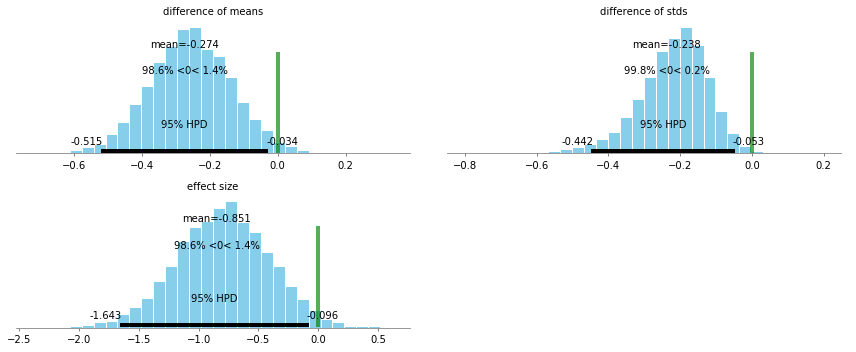

----------
0.15734884574624308


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, P-3_std, B-4_std, P-3_mean, B-4_mean]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2395.69draws/s]


	subscapularis: LOWER


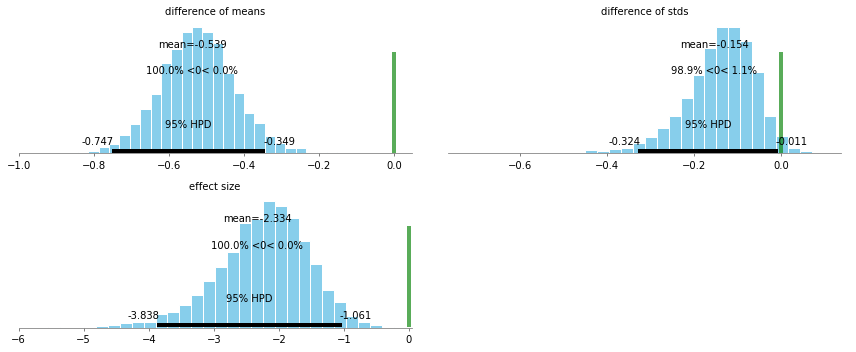

----------


In [60]:
for imuscle in MUSCLES:
    d = {'B-4': df_comp.query('method == "DM-14" & muscle == @imuscle')['mape'].dropna(), 'P-3': df_comp.query('method == "B-4" & muscle == @imuscle')['mape'].dropna()}
    m = best(d)
    with m:
        trace = pm.sample(2000, tune=2000)
        
    hpd = pm.summary(trace).loc['difference of means'].filter(like='hpd')

    if (hpd > 0).all():
        print(f'\t{imuscle}: HIGHER')
    elif (hpd < 0).all():
        print(f'\t{imuscle}: LOWER')
    else:
        print(f'\t{imuscle}: NONE')
        
    pm.plot_posterior(trace, varnames=['difference of means','difference of stds', 'effect size'], ref_val=0, alpha_level=0.05)
    plt.show()
    print(f'{"-" * 10}')

0.3585786362136827


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, P-3_std, B-4_std, P-3_mean, B-4_mean]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2194.03draws/s]


	upper trapezius: HIGHER


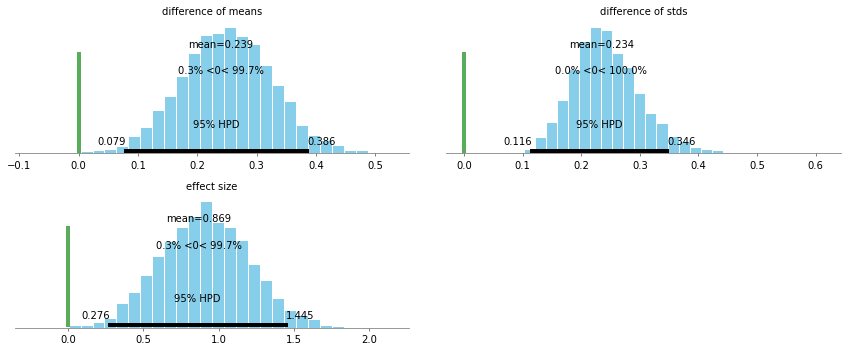

----------
0.22812419615275425


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, P-3_std, B-4_std, P-3_mean, B-4_mean]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2188.96draws/s]


	middle trapezius: NONE


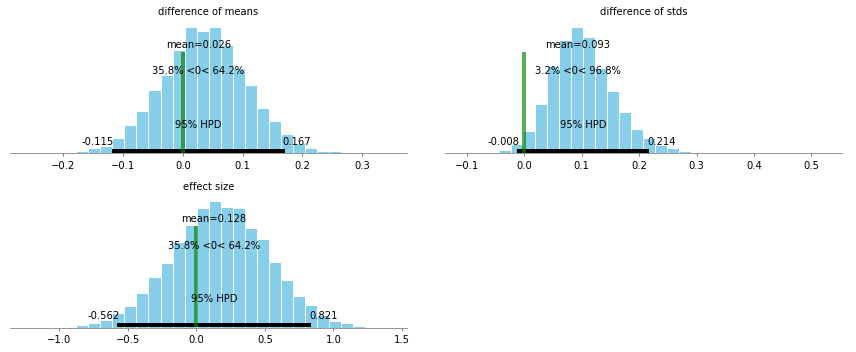

----------
0.2757538577887577


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, P-3_std, B-4_std, P-3_mean, B-4_mean]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2425.72draws/s]


	lower trapezius: HIGHER


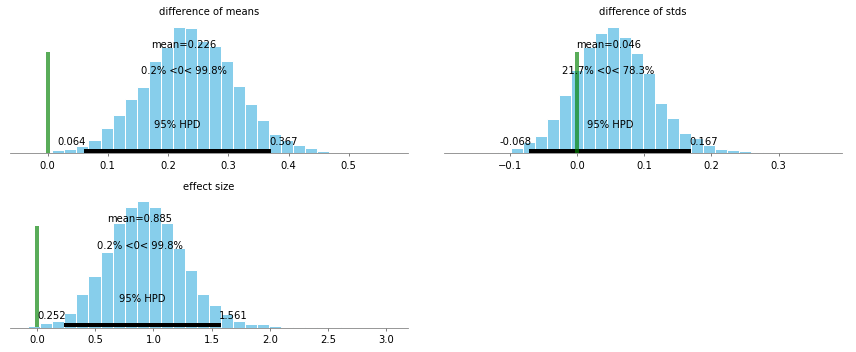

----------
0.24084563718865587


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, P-3_std, B-4_std, P-3_mean, B-4_mean]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2209.62draws/s]


	anterior deltoid: NONE


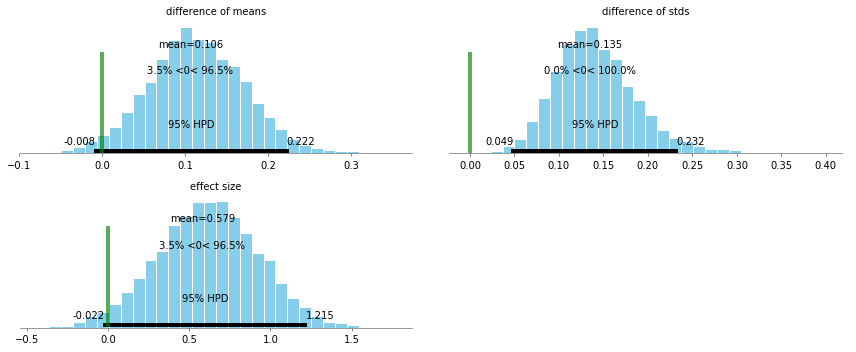

----------
0.3425973144788715


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, P-3_std, B-4_std, P-3_mean, B-4_mean]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2174.28draws/s]


	middle deltoid: HIGHER


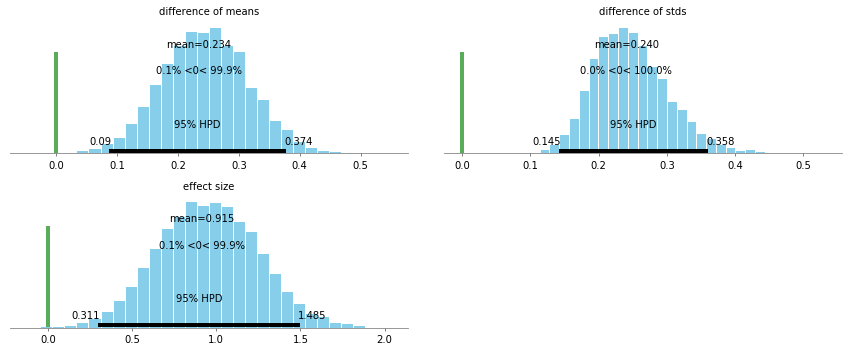

----------
0.26884830231474016


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, P-3_std, B-4_std, P-3_mean, B-4_mean]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2257.72draws/s]
The acceptance probability does not match the target. It is 0.6927207107083043, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8974440767549521, but should be close to 0.8. Try to increase the number of tuning steps.


	posterior deltoid: HIGHER


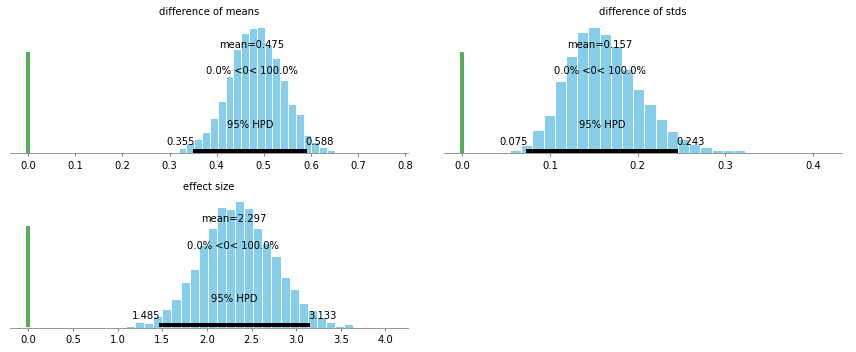

----------
0.32444980873858553


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, P-3_std, B-4_std, P-3_mean, B-4_mean]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2377.12draws/s]


	pectoralis major: NONE


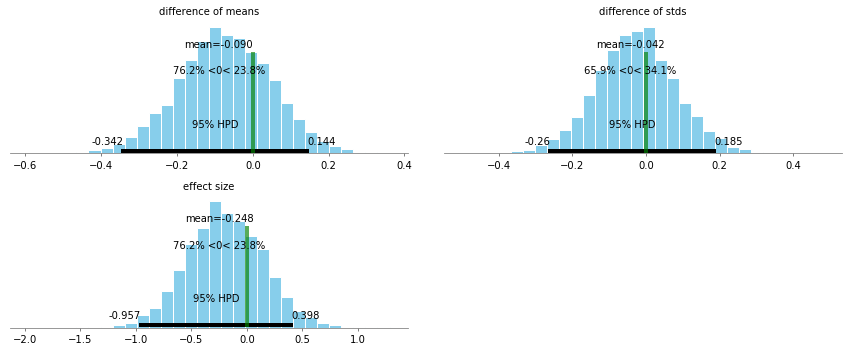

----------
0.1880187477946328


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, P-3_std, B-4_std, P-3_mean, B-4_mean]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2362.04draws/s]


	serratus anterior: NONE


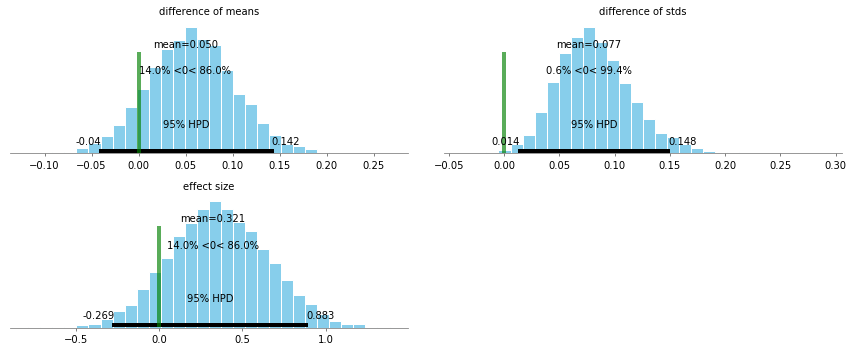

----------
0.29575358701260546


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, P-3_std, B-4_std, P-3_mean, B-4_mean]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2416.82draws/s]
The acceptance probability does not match the target. It is 0.6782312063474465, but should be close to 0.8. Try to increase the number of tuning steps.


	latissimus dorsi: HIGHER


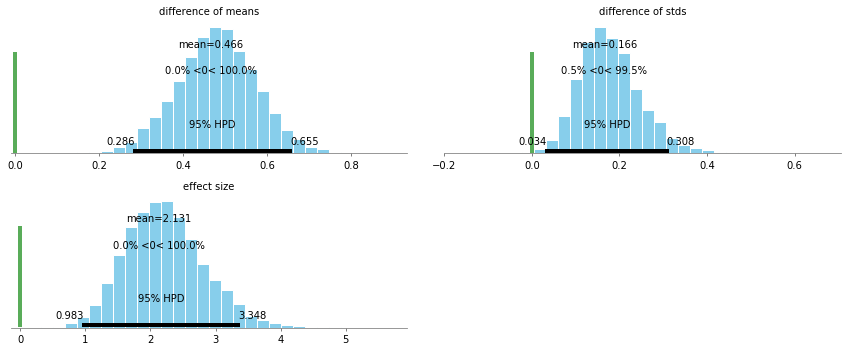

----------
0.38079185435003315


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, P-3_std, B-4_std, P-3_mean, B-4_mean]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:07<00:00, 2063.22draws/s]
The acceptance probability does not match the target. It is 0.8813475661599691, but should be close to 0.8. Try to increase the number of tuning steps.


	supraspinatus: HIGHER


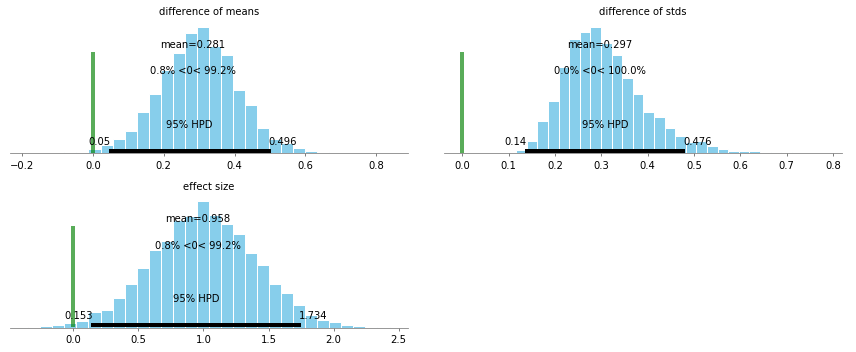

----------
0.3995918656155524


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, P-3_std, B-4_std, P-3_mean, B-4_mean]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2432.98draws/s]


	infraspinatus: NONE


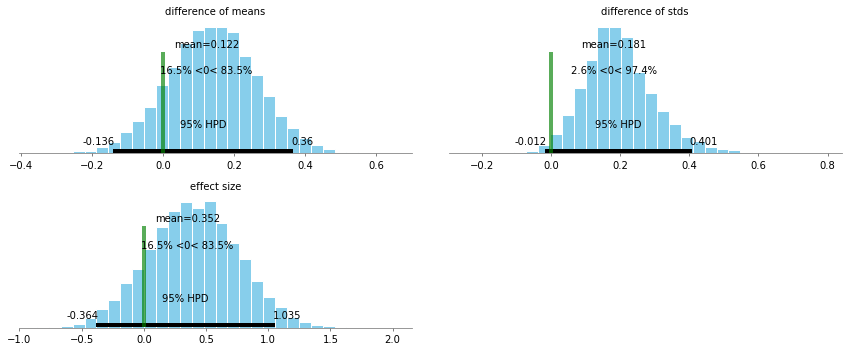

----------
0.29626963976457577


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ν_minus_one, P-3_std, B-4_std, P-3_mean, B-4_mean]
Sampling 4 chains: 100%|██████████| 16000/16000 [00:06<00:00, 2416.63draws/s]


	subscapularis: HIGHER


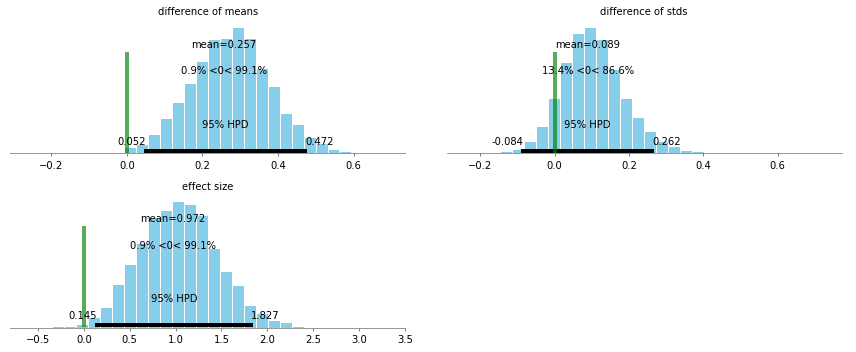

----------


In [61]:
for imuscle in MUSCLES:
    d = {'B-4': df_comp.query('method == "B-4" & muscle == @imuscle')['mape'].dropna(), 'P-3': df_comp.query('method == "P-3" & muscle == @imuscle')['mape'].dropna()}
    m = best(d)
    with m:
        trace = pm.sample(2000, tune=2000)
        
    hpd = pm.summary(trace).loc['difference of means'].filter(like='hpd')

    if (hpd > 0).all():
        print(f'\t{imuscle}: HIGHER')
    elif (hpd < 0).all():
        print(f'\t{imuscle}: LOWER')
    else:
        print(f'\t{imuscle}: NONE')
        
    pm.plot_posterior(trace, varnames=['difference of means','difference of stds', 'effect size'], ref_val=0, alpha_level=0.05)
    plt.show()
    print(f'{"-" * 10}')

### Bayes

### Compare muscle in P-3

In [184]:
SAMPLE = True
MODEL_PATH = "./models/ac_glm"

formula = "mape ~ muscle"

with pm.Model() as model:
    family = pm.glm.families.Normal()
    pm.glm.GLM.from_formula(
        formula,
        data=test_eval.dropna().assign(
            mape=lambda x: x.eval("(mape - mape.mean()) / mape.std()")
        ),
        family=family,
    )
model

In [170]:
with model:
    if SAMPLE:
        trace = pm.sample(10000, tune=2000)
        pm.save_trace(trace, directory=MODEL_PATH, overwrite=True)
    else:
        trace = pm.load_trace(MODEL_PATH, model=model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, C(muscle)[T.upper trapezius], C(muscle)[T.supraspinatus], C(muscle)[T.subscapularis], C(muscle)[T.serratus anterior], C(muscle)[T.posterior deltoid], C(muscle)[T.pectoralis major], C(muscle)[T.middle trapezius], C(muscle)[T.middle deltoid], C(muscle)[T.lower trapezius], C(muscle)[T.latissimus dorsi], C(muscle)[T.infraspinatus], Intercept]
Sampling 4 chains: 100%|██████████| 48000/48000 [01:48<00:00, 444.40draws/s]
The number of effective samples is smaller than 25% for some parameters.


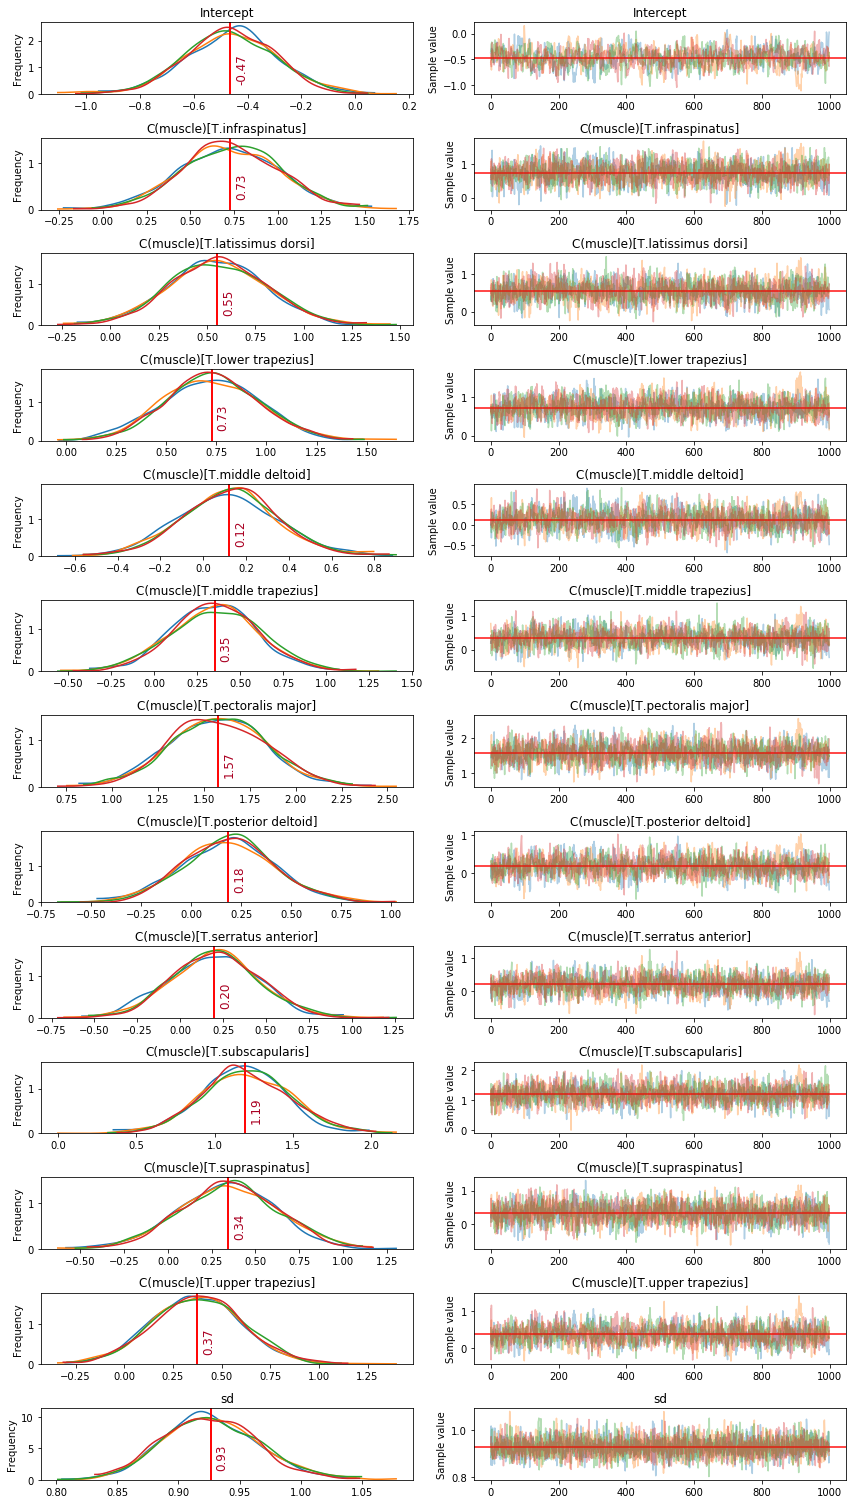

In [182]:
def plot_traces(traces, retain=1000):
    ax = pm.traceplot(
        traces[-retain:],
        figsize=(12, len(traces.varnames) * 1.5),
        lines={k: v["mean"] for k, v in pm.summary(traces[-retain:]).iterrows()},
    )
    for i, mn in enumerate(pm.summary(traces[-retain:])["mean"]):
        ax[i, 0].annotate(
            f"{mn:.2f}",
            xy=(mn, 0),
            xycoords="data",
            xytext=(5, 10),
            textcoords="offset points",
            rotation=90,
            va="bottom",
            fontsize="large",
            color="#AA0022",
        )


plot_traces(trace, retain=1000)

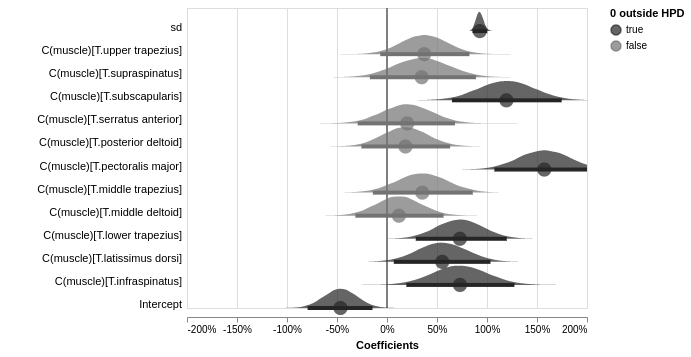

In [183]:
plot_bayes_violin(
    pm.trace_to_dataframe(trace),
    ref=0,
    domain=[-2, 2],
    xlabel="Coefficients",
    alpha=0.05,
)

### Compare methods

In [185]:
df_comp.head()

,mape,method,muscle
15,NaN,B-4,upper trapezius
39,NaN,B-4,upper trapezius
47,NaN,B-4,upper trapezius
55,NaN,B-4,upper trapezius
71,NaN,B-4,upper trapezius


In [320]:
SAMPLE = True
MODEL_PATH = "./models/ac_glm_methods"

formula = "mape ~ method"

muscle = MUSCLES[11]
print(muscle)

with pm.Model() as model:
    family = pm.glm.families.Normal()
    pm.glm.GLM.from_formula(
        formula,
        data=df_comp.query(f'muscle == "{muscle}"').dropna().assign(
            mape=lambda x: x.eval("(mape - mape.mean()) / mape.std()")
        ),
        family=family,
    )
model

subscapularis


In [321]:
with model:
    if SAMPLE:
        trace = pm.sample(10000, tune=2000)
        pm.save_trace(trace, directory=MODEL_PATH, overwrite=True)
    else:
        trace = pm.load_trace(MODEL_PATH, model=model)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sd, method[T.P-3], method[T.DM-14], Intercept]
Sampling 4 chains: 100%|██████████| 48000/48000 [00:20<00:00, 2343.87draws/s]


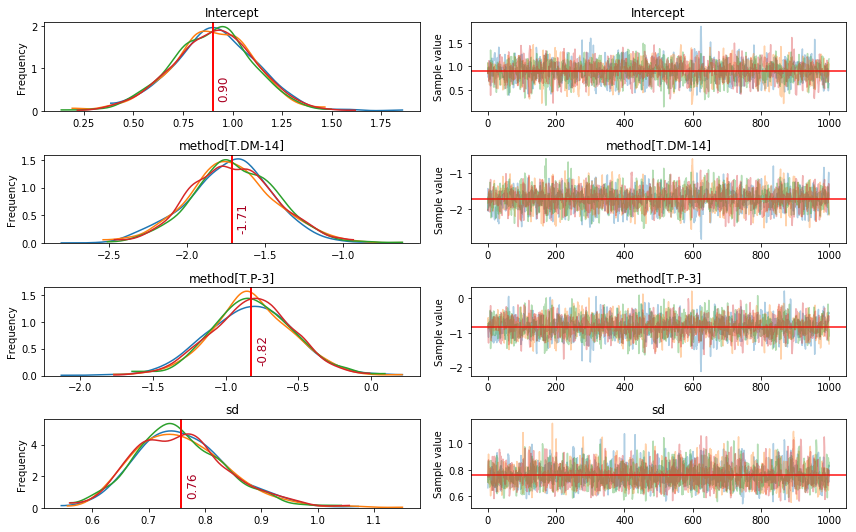

In [322]:
plot_traces(trace, retain=1000)

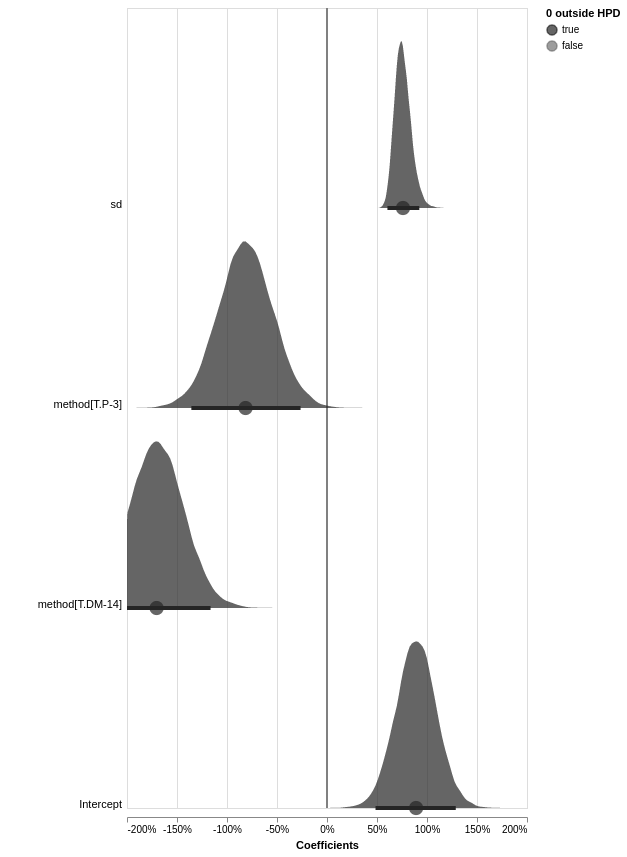

In [323]:
plot_bayes_violin(
    pm.trace_to_dataframe(trace),
    ref=0,
    domain=[-2, 2],
    xlabel="Coefficients",
    alpha=0.05,
    height=800
)

### Non-parametric stats

In [88]:
from sklearn.impute import SimpleImputer
import spm1d

ALPHA = 0.05 / (12 * 3)
N_ITER = 10000
p_value = {}

for imethod in combinations(set(df_comp["method"].unique()), 2):
    print(f"{imethod[0].upper()} vs. {imethod[1].upper()}")
    p_value[imethod] = {}
    for imuscle in MUSCLES:

        a = df_comp.query(f'muscle == "{imuscle}" & method == "{imethod[0]}"')[
            "mape"
        ].values.reshape(-1, 1)
        b = df_comp.query(f'muscle == "{imuscle}" & method == "{imethod[1]}"')[
            "mape"
        ].values.reshape(-1, 1)

        a = SimpleImputer(strategy="median").fit_transform(a)
        b = SimpleImputer(strategy="median").fit_transform(b)

        ttest = spm1d.stats.nonparam.ttest_paired(a.ravel(), b.ravel())
        ttesti = ttest.inference(alpha=ALPHA, iterations=N_ITER, two_tailed=True)

        if ttesti.h0reject:
            direction = ">" if a.mean() > b.mean() else "<"
            string = f"{imethod[0]} {direction} {imethod[1]}"
            p_value[imethod][imuscle] = ttesti.p
        else:
            string = "no differences"
            p_value[imethod][imuscle] = np.nan

        print(f"\t{imuscle}: {string}")

B-4 vs. P-3
	upper trapezius: B-4 > P-3
	middle trapezius: no differences
	lower trapezius: no differences
	anterior deltoid: no differences
	middle deltoid: B-4 > P-3
	posterior deltoid: B-4 > P-3
	pectoralis major: no differences
	serratus anterior: no differences
	latissimus dorsi: no differences
	supraspinatus: no differences
	infraspinatus: no differences
	subscapularis: no differences
B-4 vs. DM-14
	upper trapezius: B-4 > DM-14
	middle trapezius: B-4 > DM-14
	lower trapezius: B-4 > DM-14
	anterior deltoid: no differences
	middle deltoid: B-4 > DM-14
	posterior deltoid: B-4 > DM-14
	pectoralis major: B-4 > DM-14
	serratus anterior: B-4 > DM-14
	latissimus dorsi: B-4 > DM-14
	supraspinatus: B-4 > DM-14
	infraspinatus: no differences
	subscapularis: B-4 > DM-14
P-3 vs. DM-14
	upper trapezius: P-3 > DM-14
	middle trapezius: P-3 > DM-14
	lower trapezius: P-3 > DM-14
	anterior deltoid: no differences
	middle deltoid: no differences
	posterior deltoid: P-3 > DM-14
	pectoralis major: P-3

In [89]:
p = pd.DataFrame(p_value).T.reset_index()
p = (
    p.set_index(p["level_0"] + " vs " + p["level_1"])
    .drop(["level_0", "level_1"], axis=1)
    .T
)
p

,B-4 vs P-3,B-4 vs DM-14,P-3 vs DM-14
anterior deltoid,NaN,NaN,NaN
infraspinatus,NaN,NaN,NaN
latissimus dorsi,NaN,0.0001,0.0001
lower trapezius,NaN,0.0001,0.0001
middle deltoid,0.0002,0.0001,NaN
middle trapezius,NaN,0.0001,0.0001
pectoralis major,NaN,0.0001,0.0001
posterior deltoid,0.0001,0.0001,0.0001
serratus anterior,NaN,0.0002,NaN
subscapularis,NaN,0.0002,NaN


In [90]:
pd.cut(
    p.stack(),
    bins=[-np.inf, 0.0001, 0.001, 0.01, 0.05, np.inf],
    labels=["****", "***", "**", "*", "ns"],
).unstack()

,B-4 vs P-3,B-4 vs DM-14,P-3 vs DM-14
latissimus dorsi,NaN,****,****
lower trapezius,NaN,****,****
middle deltoid,***,****,NaN
middle trapezius,NaN,****,****
pectoralis major,NaN,****,****
posterior deltoid,****,****,****
serratus anterior,NaN,***,NaN
subscapularis,NaN,***,NaN
supraspinatus,NaN,****,NaN
upper trapezius,***,****,***
